In [1]:
#!pip install packagename
# importing modules
import geopandas as gpd
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib
import matplotlib.pyplot as plt
import os
from os import chdir as cd
import time
import fiona
from datetime import date

C:\Users\uttar\AppData\Local\Temp\ipykernel_7944\2650266297.py:3: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [2]:
# # Exporting all shapefiles for plotting
# # Importing the places shapefiles for all states
# # combining them into one for further use
# from pathlib import Path
# # define the file location
# folder = Path(r"D:\Work\Box Sync\Trends_all states\Maps_2020\\")
# # reading the zip file
# shapefiles = folder.glob("tl_2020_*_place.zip")
# # combining places for US into one file
# gdf = pd.concat([gpd.read_file(shp) for shp in shapefiles]).pipe(gpd.GeoDataFrame)
# gdf = gdf.set_crs("EPSG:4269")
# gdf.to_file(folder / 'compiled.shp')

In [3]:
US_places = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\compiled.shp')
US_counties = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_county.zip')
US_states = gpd.read_file(r'D:\Work\Box Sync\Trends_all states\Maps_2020\tl_2020_us_state.zip')

# source: https://gis.stackexchange.com/questions/141580/which-projection-is-best-for-mapping-the-contiguous-united-states
US_states = US_states.to_crs('EPSG:9311')
US_places = US_places.to_crs('EPSG:9311')
US_counties = US_counties.to_crs('EPSG:9311')

US_places.shape, US_counties.shape, US_states.shape

((32188, 17), (3234, 18), (56, 15))

In [4]:
US_places.groupby(['STATEFP'])['GEOID'].count().sum()

32188

In [5]:
# census population from 2020 data
places_census2020 = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Population_DP05\DECENNIALPL2020.P1-Data.csv')
places_census2020 = places_census2020.tail(-1)
places_census2020
places_census2020['GEOID'] = places_census2020['GEO_ID'].str.slice(-7)
places_census2020['CensusPop_20'] = places_census2020['P1_001N'].astype(float)
population_2020 = places_census2020[['GEOID', 'CensusPop_20']]

C:\Users\uttar\AppData\Local\Temp\ipykernel_7944\18581248.py:2: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  places_census2020 = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Population_DP05\DECENNIALPL2020.P1-Data.csv')
C:\Users\uttar\AppData\Local\Temp\ipykernel_7944\18581248.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [6]:
places_with_population = US_places.merge(population_2020 , on = 'GEOID', how = 'outer')

In [7]:
# replacing zero population values with NaN
places_with_population['CensusPop_20'].replace(0, np.nan, inplace = True)
places_with_population['CensusPop_20'].isna().sum(), places_with_population.shape

(327, (32188, 18))

In [8]:
# import Mann_kendall analysis output found from mk_Trend.py
# for all places in the US
# the places that had trend identified is only listed in this file
places_attr = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\mktest_place_10-20_Continued_labeled.csv')
places_attr['P_19'] = places_attr['Pop_estimate'].str.split(',').str[-2].str.strip('[]').astype(float)
places_attr.rename(columns = {'NAME_x': 'NAME'}, inplace = True)
# slicing column value to match with shapefile for joining
places_attr['GEOID'] = places_attr['GEO_ID'].str.slice(-7)
places_attr['State'] = places_attr['GEOID'].str[:2]
# places_attr = places_attr[places_attr['State'] == state_code]
#places_attr.head()
places_attr.shape

(29245, 34)

In [9]:
# Check number of values found from estimation
places_attr['label'].value_counts().sum(), places_attr['label'].value_counts()/ places_attr['label'].value_counts().sum()

(29245,
 3 slowly depopulating        0.308326
 6 moderately increasing      0.249547
 5 slowly increasing          0.192443
 7 highly increasing          0.102650
 2 moderately depopulating    0.063361
 4 fluctuating                0.050573
 1 severely depopulating      0.033100
 Name: label, dtype: float64)

In [10]:
# places_attr[['DP05_0001E', 'DP05_0001E_11','DP05_0001E_12', 'DP05_0001E_13', 'DP05_0001E_14', 'DP05_0001E_15',
#        'DP05_0001E_16', 'DP05_0001E_17', 'DP05_0001E_18', 'DP05_0001E_19', 'DP05_0001E_20']].sum().plot()

In [11]:
# joining tabular data with spatial data 
# by merging the data files based on column name
# use 'outer' join and check unmatched datanames
places_merged_all = places_with_population.merge(places_attr.loc[:,['GEOID','Pop_estimate', 'P_19', 'P_20', 'trend','label', 'State']],
                                    on = 'GEOID', 
                                    how = 'outer', 
                                    indicator=True)

In [12]:
places_merged_all.shape, places_merged_all.columns

((32188, 25),
 Index(['STATEFP', 'PLACEFP', 'PLACENS', 'GEOID', 'NAME', 'NAMELSAD', 'LSAD',
        'CLASSFP', 'PCICBSA', 'PCINECTA', 'MTFCC', 'FUNCSTAT', 'ALAND',
        'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry', 'CensusPop_20',
        'Pop_estimate', 'P_19', 'P_20', 'trend', 'label', 'State', '_merge'],
       dtype='object'))

In [13]:
# places that exist in the geographic file (US_places) but not in population data
# these are places that changed NAME, GEOID or Both or merged or dropped
# they will be checked manually and analyzed separately
places_merged_all[places_merged_all['_merge'] == 'left_only'].sort_values('NAME').groupby(['STATEFP']).agg({'GEOID':'count',
                                                                                                            'P_19':'sum',
                                                                                                            'P_20':'sum',
                                                                                                            'CensusPop_20':'sum'}).sum()

# places_merged_all[places_merged_all['_merge'] == 'left_only'][['GEOID', 'NAME', 'NAMELSAD','Pop_estimate',]]

GEOID              2943.0
P_19                  0.0
P_20                  0.0
CensusPop_20    4154494.0
dtype: float64

In [14]:
# excluding NaN values for census population since that will result in non-numeric population factor
places_merged = places_merged_all[places_merged_all['CensusPop_20'].notnull()] # places_merged_all[places_merged_all['_merge'] == 'both']
print(places_merged.shape)
# Excluding Puerto Rico since Hauer's forecast do not have values for Puerto Rico
places_merged = places_merged[places_merged['STATEFP'] != '72']
places_merged.shape

(31861, 25)


(31569, 25)

In [15]:
# places_merged[['STATEFP','GEOID', 'NAMELSAD','ALAND','CensusPop_20', 'Pop_estimate', 'P_19', 'P_20', 'trend', 'label', '_merge']]

In [16]:
# County population from Census
county_population = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\County Population\DECENNIALPL2020.P1-Data.csv', header = 1)
county_population.shape, county_population[' !!Total:'].sum()

((3221, 145), 334735155)

In [17]:
# loading forecasted population data from Hauer
%cd "D:\Work\Box Sync\Depop Population forecasting\NASA SEDAC data\county_projectios_Total_bySex_byRace\total_pop_proj"
county_Projection = gpd.read_file(r"hauer_county_totpop_SSPs.shp")

# contains 3221 rows, 3135 rows contains forecast values, these 3135 rows will be used for analysis
print(county_Projection.shape)

# 78 rows with zero data for counties in Puerto Rico  # county_Projection[county_Projection['STATEFP10'] == '72']
# county_Projection = county_Projection[county_Projection['ssp22020'] != 0]
# check coordinate system and project to similar coordinate system
# to change the coordinate system
county_Projection = county_Projection.to_crs('3528')
if county_Projection.crs != places_merged.crs:
    places_merged = places_merged.to_crs(county_Projection.crs)

D:\Work\Box Sync\Depop Population forecasting\NASA SEDAC data\county_projectios_Total_bySex_byRace\total_pop_proj
(3221, 104)


In [18]:
county_Projection.shape

(3221, 104)

In [19]:
county_population['Total population'] = county_population[' !!Total:'].astype('float')
county_population['GEOID10'] = county_population['Geography'].str.slice(-5)
county_with_population = county_Projection.merge(county_population[['GEOID10', 'Geographic Area Name',
                                                               'Total population']], on = 'GEOID10', how = 'outer', indicator = True)

In [20]:
# county_with_population[county_with_population['_merge'] == 'left_only']
# county_with_population[county_with_population['_merge'] == 'right_only']
# county_with_population[county_with_population['NAME10'].str.contains('Bedford') == True]

In [21]:
county_with_population['Total population'].dtypes
# Manual correction
county_with_population.loc[625,105] = 9719.0   # On January 2, 2019, it was abolished and replaced by the Chugach Census Area and the Copper River Census Area
county_with_population.loc[2754,105] = 13672.0 # Oglala Lakota County (known as Shannon County until May 2015
county_with_population.loc[173,105] = 8368 # Kusilvak Census Area, formerly known as Wade Hampton Census Area

In [22]:
# county_Projection.columns
# total population in the US
# As of the census, 26% of the people in the United States lived outside of places
# places_merged['P_20'].sum()/(1-0.26), places_merged['CensusPop_20'].sum()/(1-0.26)


In [23]:
df_P_20_with_margin = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\Population_2020_with_margin.csv')
df_P_20_with_margin['GEOID'] = df_P_20_with_margin['GEO_ID'].str.slice(-7)

In [24]:
combined_df = pd.DataFrame()
gdf = pd.DataFrame()

for state in county_Projection['STATEFP10'].sort_values().unique():
    # print('start...')
    # print('........')
    population_projection =  county_with_population[county_with_population['STATEFP10'] == state]
    places_population = places_merged[places_merged['STATEFP'] == state]
    
    # print(population_projection.head())
    # print('........')
    # print(places_population.head())
    
    if population_projection.crs == places_population.crs:
        # calculating total area from geometry # try using land/water ratio???? # didnt use geom_area, used ALAND area
        geom_overlayed = gpd.overlay(population_projection, places_population, how='intersection', keep_geom_type=False, make_valid=True)

        geom_overlayed['intersect_area'] = geom_overlayed.area
    
        geom_overlayed['%area'] = geom_overlayed['intersect_area'] /geom_overlayed['ALAND'] 
        geom_overlayed['area_factor'] = geom_overlayed.groupby(by = ['GEOID'])['%area'].apply(lambda x:(x/x.sum()))
        geom_overlayed['landarea'] = geom_overlayed['ALAND'] / (1000*1000)
        # density in km2
        geom_overlayed['density'] = geom_overlayed['CensusPop_20']/geom_overlayed['landarea'] # 'P_20'
        geom_overlayed['P_20_adjusted'] = geom_overlayed['area_factor'] * geom_overlayed['density'] * geom_overlayed['landarea']
        # what percent of county population lives in this place
        geom_overlayed['population_factor'] = geom_overlayed['P_20_adjusted'] / geom_overlayed['Total population'] #.apply(lambda x:(x/x.sum()))
    
        # geom_overlayed['population_factor'] = geom_overlayed.groupby(by = ['STATEFP', 'NAMELSAD10'])['P_20_adjusted'].apply(lambda x:(x/x.sum()))
        geom_overlayed['population_factor'] = geom_overlayed['population_factor'].fillna(0)
        # normalizing population factor so that county total becomes 1
        # geom_overlayed['population_factor'] = geom_overlayed.groupby(by = ['STATEFP10', 'NAMELSAD10'])['population_factor'].apply(lambda x:(x/x.sum()))
        # print(geom_overlayed.shape)
        for colidx in range(18,103):                # columns that contains county sums
            column_name =  'forecast_' + str(geom_overlayed.columns[colidx])
            geom_overlayed[column_name] = (geom_overlayed.iloc[:,colidx] * geom_overlayed['population_factor']).round(0)
        
        # gdf is used to make the plot
        # gdf contains ungrouped data by GEOID
        gdf = pd.concat([gdf, geom_overlayed])
    
        column_name = geom_overlayed.columns[139:234] # taking the columns that have forecasted dataset
        print('for check: ' + column_name[0] + ' ' + column_name[-1])
        forecasted_df = pd.DataFrame()
        forecasted_df = geom_overlayed.groupby(by = ['GEOID', 'CensusPop_20'], as_index=False)[column_name].apply(lambda x:(x.sum()))

        county_names = geom_overlayed.groupby(by = ['GEOID'], as_index=False).agg({'COUNTYFP10': 'first', 'NAME10': 'count'})
        forecasted_df =  forecasted_df.merge(county_names, on = 'GEOID')
    
    
        df_with_MOE = forecasted_df.merge(df_P_20_with_margin[df_P_20_with_margin['GEOID'].str.startswith(state)][['P_20_upper', 
                                                                                                               'P_20_lower','NAME', 'GEOID',]], on = 'GEOID')
    
        df_with_MOE['MOE'] = (df_with_MOE['P_20_upper']- df_with_MOE['P_20_lower'])/2
        df_with_MOE['diff'] = (df_with_MOE['P_20_upper']- df_with_MOE['MOE']- df_with_MOE['forecast_ssp32020'])
        df_with_MOE['diff'] = df_with_MOE['diff'].replace(-np.inf, np.nan)
        # print('Completed for state: ' + state)

        combined_df = pd.concat([combined_df, df_with_MOE])
    else:
        print('check coordinate system')
    
    
    
combined_df.shape

for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: forecast_ssp12020 forecast_ssp52100
for check: fo

(31568, 94)

In [25]:
# gdf.groupby(['STATEFP', 'GEOID']).agg({'NAMELSAD': 'first',
#                                      'ssp32020':'first', # 'STATEFP','GEOID',
#                                     'P_19':'first',
#                                     'P_20': 'first',
#                                     'forecast_ssp32020': 'sum',
#                                     # 'area_factor':'sum',
#                                     'population_factor':'sum',
#                                     # 'diff':'sum',
#                                    # 'ALAND':'first',
#                                   }) #.sort_values('diff') #.reset_index() #.sort_values('NAMELSAD')

# gdf[['GEOID', 'NAMELSAD','population_factor','P_19', 'P_20', 'CensusPop_20', 'trend', 'label', 'State',
#                 # 'intersect_area', '%area', 'area_factor', 
#      'landarea', 'density', 'P_20_adjusted', ]].sort_values(['NAMELSAD', 'GEOID',]).head(20)

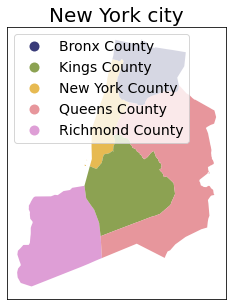

In [26]:
# =====================================================
# # find the city that is overlaped by maximum counties
# =====================================================
city_name = 'New York city'
plotting_city = gdf[(gdf['NAMELSAD'] ==city_name) & (gdf['%area'] > 0.001)]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(5, 5))
# county_IL[county_IL['NAME'] == 'Kane'].plot(ax= ax, edgecolor = 'green',  facecolor = 'none')
# county_IL[county_IL['NAME'] == 'Kendall'].plot(ax= ax, edgecolor = 'red', facecolor = 'none')
# county_IL[county_IL['NAME'] == 'DuPage'].plot(ax= ax, edgecolor = 'blue', facecolor = 'none')
# county_IL[county_IL['NAME'] == 'Will'].plot(ax= ax, edgecolor = 'pink', facecolor = 'none')#, column = 'NAME10', legend = True, cmap = 'tab20b', legend_kwds={'loc': 'lower left',})
plotting_city.plot(ax= ax, column = 'NAMELSAD10', legend = True, 
                   cmap = 'tab20b', legend_kwds={'loc': 'upper left','fontsize': 14})
ax.set_title(str(city_name), fontsize=20, pad=5)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
fig.savefig(r'D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\forecast trend output\Figures\\' + str(city_name) + '.png', dpi =300, bbox_inches='tight')


In [27]:
df_Hauer = combined_df.reset_index(drop= True).copy()

In [28]:
pop_from_NCAR = pd.read_csv(r'D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\r_concat_SSP\NCAR_agg_scenarios.csv',
                            index_col = 0, dtype = {'GEOID_ssp5': str})

df_NCAR = pop_from_NCAR.copy()
print(df_NCAR.shape, df_Hauer.shape,)

(32188, 160) (31568, 94)


In [29]:
# THIS IS FROM UNWEIGHTED DATA FOUND FROM PYTHON RASTER TO VECTOR ZONAL STAT EXTRACTION 
# ==================================================================================================================
# trend_from_SSP = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\df_trend_from_SSPs_new.csv', 
#                              index_col = 0, dtype = {'GEOID_SSP_1': str})
# trend_from_SSP.drop(['GEOID_SSP_2', 'GEOID_SSP_3', 'GEOID_SSP_4', 'GEOID_SSP_5'], axis =1, inplace = True)
# df_NCAR = trend_from_SSP.copy()
df_NCAR[df_NCAR['population_2020_ssp4'] == 0].shape, df_Hauer[df_Hauer['forecast_ssp42020'] == 0].shape
print(df_NCAR.shape, df_Hauer.shape,)
# df_both_combined = df_hauer.merge(df_NCAR, left_on = 'GEOID', right_on = 'GEOID_SSP_1')

(32188, 160) (31568, 94)


In [30]:
# MERGING TWO DATASETS

In [31]:
right_on_column_name = 'GEOID_ssp5'
df_both_combined = df_Hauer.merge(df_NCAR, left_on = 'GEOID', right_on = right_on_column_name, how = 'outer', indicator = True )
# df_both_combined.columns, 
df_both_combined.shape

(32188, 255)

In [32]:
df_both_combined.columns

Index(['GEOID', 'CensusPop_20', 'forecast_ssp12020', 'forecast_ssp22020',
       'forecast_ssp32020', 'forecast_ssp42020', 'forecast_ssp52020',
       'forecast_ssp12025', 'forecast_ssp22025', 'forecast_ssp32025',
       ...
       'std_2080_ssp5', 'population_2090_ssp5', 'meanpop_2090_ssp5',
       'std_2090_ssp5', 'NAMELSAD_2100_ssp5', 'population_2100_ssp5',
       'meanpop_2100_ssp5', 'std_2100_ssp5', 'GEOID_ssp5', '_merge'],
      dtype='object', length=255)

In [33]:
df_both_combined[df_both_combined['_merge'] == 'left_only'].shape, \
df_both_combined[df_both_combined['_merge'] == 'right_only'].shape, \
df_both_combined[df_both_combined['_merge'] == 'both'].shape, 

((0, 255), (620, 255), (31568, 255))

In [34]:
# df_both_combined[(df_both_combined['_merge'] == 'right_only') & (df_both_combined['GEOID_ssp5'].str.startswith('02'))]

In [35]:
# CHECKING MISMATCHED REMIANING CELLS
# df_both_combined[df_both_combined['NAME'].str.contains('Louisville', na=False)][['GEOID', 'NAME','CensusPop_20', 
#                                                                                  'forecast_ssp42020', 'forecast_ssp42060',
#                                                                                  'population_2020_ssp4', 'population_2060_ssp4']]

# df_both_combined[(df_both_combined['_merge'] == 'right_only') & \
#                  (df_both_combined['population_2020_ssp4'] > 5000)][['NAMELSAD_2100_ssp5', 'population_2020_ssp4',
#                                                                      'meanpop_2020_ssp4', 'std_2020_ssp4', 
#                                                                      'GEOID_ssp5']].sort_values(by = 'population_2020_ssp4')

In [36]:
# Common to both dataframes
df_complete = df_both_combined[df_both_combined['_merge'] == 'both'].reset_index(drop=True)
print('no of cities common to both datasets: ' + str(df_complete.shape[0]))

no of cities common to both datasets: 31568


In [37]:
# df_both_combined[['GEOID', 'CensusPop_20', 'forecast_ssp12020',  'forecast_ssp22020', 'forecast_ssp42020',  'forecast_ssp52020',
#                   'sum2020_SSP_1', 'sum2020_SSP_2', 'sum2020_SSP_3', 'sum2020_SSP_4', 'sum2020_SSP_5']].head(20)

In [38]:
# df_complete

In [39]:
# # create weights
# df_complete['weights_%diff_Hauer'] = 1/(np.abs(df_complete['forecast_ssp22020']-df_complete['CensusPop_20'])/df_complete['CensusPop_20'])
# df_complete['weights_%diff_NCAR'] = 1/(np.abs(df_complete[ 'sum2020_SSP_2']-df_complete['CensusPop_20'])/df_complete['CensusPop_20'])

In [40]:
# df_complete[['GEOID', 'CensusPop_20', 'forecast_ssp22020', 'sum2020_SSP_2', '%diff_Hauer', '%diff_NCAR']].isna().sum() #.tail(40)

In [41]:
def df_total_population(dataframe, filter_regex,label_name, *list_of_years):
    list_of_years = [2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2080, 2085, 2090, 2095, 2100]
    df = (dataframe[(dataframe.filter(regex=filter_regex).columns)].sum()/1000000).to_frame(
    name= label_name).reset_index(drop= True)
    df['Year'] = pd.to_datetime(list_of_years,  format='%Y')
    return df
    
df_ssp1 = df_total_population(df_complete,'forecast_ssp1', 'Hauer SSP 1',)
df_ssp2 = df_total_population(df_complete,'forecast_ssp2', 'Hauer SSP 2',)
df_ssp3 = df_total_population(df_complete,'forecast_ssp3', 'Hauer SSP 3',)
df_ssp4 = df_total_population(df_complete,'forecast_ssp4', 'Hauer SSP 4',)
df_ssp5 = df_total_population(df_complete,'forecast_ssp5', 'Hauer SSP 5',)
df_ssp1 = df_total_population(df_complete,'forecast_ssp1', 'Hauer SSP 1',)
df_ssp2 = df_total_population(df_complete,'forecast_ssp2', 'Hauer SSP 2',)
df_ssp3 = df_total_population(df_complete,'forecast_ssp3', 'Hauer SSP 3',)
df_ssp4 = df_total_population(df_complete,'forecast_ssp4', 'Hauer SSP 4',)
df_ssp5 = df_total_population(df_complete,'forecast_ssp5', 'Hauer SSP 5',)

# EXCLUDING STATE 72 SINCE FORECASTS DO NOT CONTAIN PUERTO RICO
places_pop_ACS = places_attr[places_attr['State'] != 72]
df_ACS = (places_pop_ACS[(places_pop_ACS.filter(regex='DP05_0001E').columns)].sum()/1000000).to_frame(
    name= 'Total_population from ACS').reset_index(drop= True)

df_ACS['Year'] = pd.to_datetime([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],  format='%Y')
# Replacing ACS 2020 value by Census value 2020
df_ACS.iloc[10,0] = places_pop_ACS.merge(df_complete[['GEOID', 'CensusPop_20']], on = 'GEOID', how = 'left')['CensusPop_20'].sum()/1000000

Text(0.5, 1.0, 'US population in millions for all places as defined by the US census')

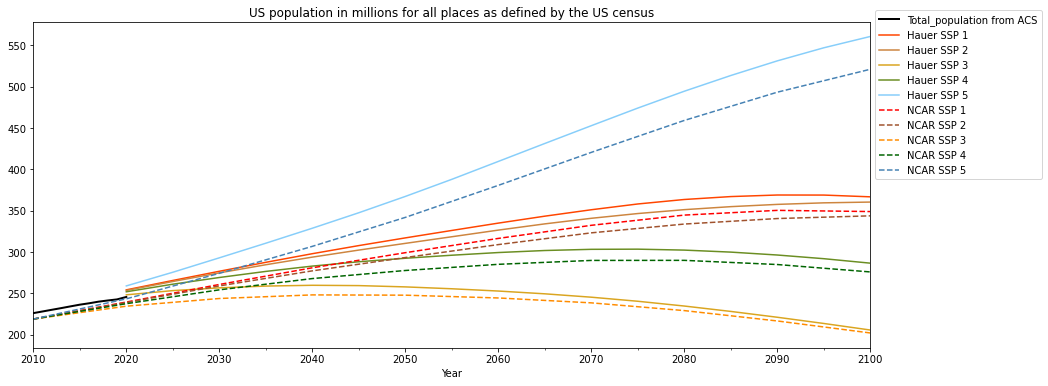

In [42]:
fig, ax = plt.subplots(1,1, figsize=(15,6))
df_ACS.plot(ax=ax, x= 'Year', y = 'Total_population from ACS', color = 'black', linewidth = 2, alpha = 1)
df_ssp1.plot(ax=ax, x= 'Year', y = 'Hauer SSP 1', color = 'orangered')
df_ssp2.plot(ax=ax, x= 'Year', y = 'Hauer SSP 2', color = 'peru', )
df_ssp3.plot(ax=ax, x= 'Year', y = 'Hauer SSP 3', color = 'goldenrod', )
df_ssp4.plot(ax=ax, x= 'Year', y = 'Hauer SSP 4', color = 'olivedrab', )
df_ssp5.plot(ax=ax, x= 'Year', y = 'Hauer SSP 5', color = 'lightskyblue',)

# df_total_pop_ssp = pd.read_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\df_total_pop_from_SSPs_new.csv', index_col = 0,)
df_total_pop_ssp = pd.read_csv(r'D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\r_concat_SSP\NCAR_agg_scenarios_totals.csv')
df_total_pop_ssp['Year'] = pd.to_datetime(['2010', '2020', '2030', '2040', '2050', '2060', '2070', '2080', '2090', '2100'],  format='%Y')
# df_total_pop_ssp = df_total_pop_ssp.iloc[:3,:]
df_total_pop_ssp.columns
df_total_pop_ssp.plot(ax=ax, x = 'Year', y = ['NCAR SSP 1', 'NCAR SSP 2', 'NCAR SSP 3', 'NCAR SSP 4', 'NCAR SSP 5'], 
                      color = ['red', 'sienna', 'darkorange', 'darkgreen', 'steelblue'], linestyle = 'dashed')
ax.legend(bbox_to_anchor=(1, 1.05))

ax.set_title('US population in millions for all places as defined by the US census', pad =5)

In [43]:
df_complete.columns

Index(['GEOID', 'CensusPop_20', 'forecast_ssp12020', 'forecast_ssp22020',
       'forecast_ssp32020', 'forecast_ssp42020', 'forecast_ssp52020',
       'forecast_ssp12025', 'forecast_ssp22025', 'forecast_ssp32025',
       ...
       'std_2080_ssp5', 'population_2090_ssp5', 'meanpop_2090_ssp5',
       'std_2090_ssp5', 'NAMELSAD_2100_ssp5', 'population_2100_ssp5',
       'meanpop_2100_ssp5', 'std_2100_ssp5', 'GEOID_ssp5', '_merge'],
      dtype='object', length=255)

In [44]:
# diff of error terms: https://www.baeldung.com/cs/mape-vs-wape-vs-wmape
# ======================================================================

df_MAPE = df_complete.copy()

print(df_MAPE.shape)


# MEAN ABSOLUTE PERCENT ERROR
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

def calculate_mape(df, actual_col, predict_col):
    return round(MAPE(df[actual_col], df[predict_col]), 2)

# MAPE < 10 is considered good forecast from the source below
# https://www.researchgate.net/publication/257812432_Using_the_R-MAPE_index_as_a_resistant_measure_of_forecast_accuracy/citations

error_from_hauer_mape = [calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp12020'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp22020'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp32020'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp42020'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'forecast_ssp52020')]

error_from_NCAR_mape = [calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp1'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp2'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp3'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp4'),
                    calculate_mape(df_MAPE, 'CensusPop_20', 'population_2020_ssp5')]

# print('\n')
# print('Mean absolute percent error for Hauer and NCAR respectively:---')
# print(error_from_hauer, error_from_NCAR)

# WEIGHTED ABSOLUTE PERCENT ERROR (WAPE)
#Defining MAPE function
def WAPE(Y_actual,Y_Predicted):
    wape = np.sum(np.abs(Y_actual - Y_Predicted)) *100/np.sum(Y_actual)
    return wape

def calculate_wape(df, actual_col, predict_col):
    return WAPE(df[actual_col], df[predict_col]).round(2)


error_from_hauer_wape = [calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp12020'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp22020'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp32020'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp42020'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'forecast_ssp52020')]

error_from_NCAR_wape = [calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp1'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp2'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp3'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp4'),
                    calculate_wape(df_MAPE, 'CensusPop_20', 'population_2020_ssp5')]

# print('\n')
# print('Weighted absolute percent error for Hauer and NCAR respectively:---')
# print(error_from_hauer, error_from_NCAR)

# WEIGHTED MEAN ABSOLUTE PERCENT ERROR (WMAPE)
#Defining WMAPE function
def WMAPE(Y_actual,Y_Predicted, weights):
    wmape = np.sum(np.abs(Y_actual - Y_Predicted)* weights) *100/np.sum(Y_actual*weights)
    return wmape

def calculate_wmape(df, actual_col, predict_col, weight_col):
    return WMAPE(df[actual_col], df_MAPE[predict_col], df_MAPE[weight_col]).round(2)

df_MAPE['normalized_pop']= (df_MAPE['CensusPop_20'] - df_MAPE['CensusPop_20'].min())/(df_MAPE['CensusPop_20'].max()-df_MAPE['CensusPop_20'].min())

error_from_hauer_wmape = [calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp12020', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp22020', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp32020', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp42020', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20', 'forecast_ssp52020', 'normalized_pop')]

error_from_NCAR_wmape = [calculate_wmape(df_MAPE, 'CensusPop_20', 'population_2020_ssp1', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20','population_2020_ssp2', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20','population_2020_ssp3', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20','population_2020_ssp4', 'normalized_pop'),
                    calculate_wmape(df_MAPE, 'CensusPop_20','population_2020_ssp5', 'normalized_pop')]



(31568, 255)


Text(0.5, 1.0, 'Absolute Percent Errors \n (weighted by population)')

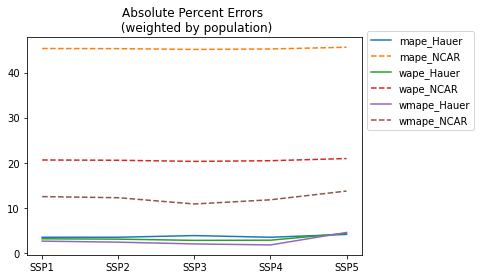

In [45]:
error_values_hauer1 = error_from_hauer_mape
error_values_NCAR1 = error_from_NCAR_mape
error_values_hauer2 = error_from_hauer_wape
error_values_NCAR2 = error_from_NCAR_wape
error_values_hauer2 = error_from_hauer_wape
error_values_NCAR2 = error_from_NCAR_wape
error_values_hauer3 = error_from_hauer_wmape
error_values_NCAR3 = error_from_NCAR_wmape

plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_hauer1, label="mape_Hauer")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_NCAR1, '--', label="mape_NCAR")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_hauer2, label="wape_Hauer")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_NCAR2, '--', label="wape_NCAR")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_hauer3, label="wmape_Hauer")
plt.plot(['SSP1','SSP2','SSP3','SSP4','SSP5'], error_values_NCAR3, '--', label="wmape_NCAR")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.title('Absolute Percent Errors \n (weighted by population)')

In [46]:
'''
Since Hauer's data over predict and NCAR underpredict we use an weighted average of these two for SSP 1, 2 and 4. 
We dropped 3 and 5 since 5 shows an insanely high pattern and the baseline conditions that is huge dependence on fossil fuel is not possible. 
SSP 3 shows an rapid decreasing rate in population, which is no way align with current population trend.
'''

"\nSince Hauer's data over predict and NCAR underpredict we use an weighted average of these two for SSP 1, 2 and 4. \nWe dropped 3 and 5 since 5 shows an insanely high pattern and the baseline conditions that is huge dependence on fossil fuel is not possible. \nSSP 3 shows an rapid decreasing rate in population, which is no way align with current population trend.\n"

In [47]:
len(df_complete.filter(regex= 'forecast').columns), len(df_complete.filter(regex= 'population_').columns)

(85, 50)

In [48]:
# df_complete[(df_complete['population_2020_ssp4'] == 0) & \
#             (df_complete['GEOID'].str.startswith('06'))][['GEOID', 'NAME','forecast_ssp42020', 'population_2020_ssp4','CensusPop_20']]

# 15 CITIES IN ALASKA ARE COMMON WITH NO FORECAST AVAILABLE
df_complete[(df_complete['population_2020_ssp4'] == 0) & (df_complete['forecast_ssp42020'] == 0)][['GEOID', 'NAME','forecast_ssp42020', 
                                                                                                   'population_2020_ssp4','CensusPop_20']]
# 155 CITIES HAVE NO FORECAST AVAILABLE FROM NCAR DATA, THEY HAVE A MEAN POPULATION OF 228 with maximum 3102
# THIS ARE CITIES FROM ALASKA - California - NEVADA - New Mexico - 	Oregon - South Dakota - Wyoming
df_complete[df_complete['population_2020_ssp4'] == 0][['GEOID', 'NAME','forecast_ssp42020', 'population_2020_ssp4','CensusPop_20']]
# 73 CITIES HAVE NO FORECAST AVAILABLE FROM HAUER DATA, THEY HAVE A MEAN POPULATION OF 533 with maximum 3985
# THIS ARE CITIES FROM ALASKA AND SOUTH DAKOTA
df_complete[df_complete['forecast_ssp42020'] == 0][['GEOID', 'NAME','forecast_ssp42020', 'population_2020_ssp4','CensusPop_20']]
df_complete[['forecast_ssp42020','population_2020_ssp4','CensusPop_20']].isna().sum()

forecast_ssp42020       0
population_2020_ssp4    0
CensusPop_20            0
dtype: int64

<AxesSubplot:>

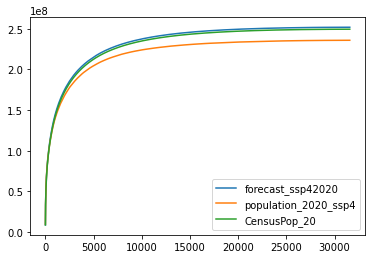

In [49]:
df_cumsum = df_complete[['forecast_ssp42020','population_2020_ssp4','CensusPop_20']].sort_values(by= 'CensusPop_20', ascending = False).reset_index(drop= True)
df_cumsum.cumsum().plot()

In [50]:
df_complete['%diff_Hauer'] = (df_complete['CensusPop_20'] - df_complete['forecast_ssp42020']) / df_complete['CensusPop_20']
df_complete['%diff_NCAR'] = (df_complete['CensusPop_20'] - df_complete['population_2020_ssp4']) / df_complete['CensusPop_20']
df_complete_middle = df_complete[((df_complete['%diff_Hauer'] >= 0) & (df_complete['%diff_NCAR'] <= 0)) | \
                                 ((df_complete['%diff_Hauer'] <= 0) & (df_complete['%diff_NCAR'] >= 0))]
df_complete_middle.shape

(15269, 257)

1140.7534002061957


<AxesSubplot:>

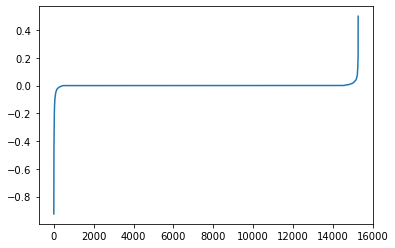

In [51]:
df11 = df_complete_middle.copy()

df11['diff_Hauer'] = np.abs(df11['CensusPop_20'] - df11['forecast_ssp42020']) 
df11['diff_NCAR'] = np.abs(df11['CensusPop_20'] - df11['population_2020_ssp4']) 


df11['w1']  = 1 / df11['diff_Hauer'] #(df_complete['diff_Hauer'] - min_val) / (max_val - min_val)
df11['w2']  = 1 / df11['diff_NCAR'] #(df_complete['diff_NCAR'] - min_val) / (max_val - min_val)

# df_complete['w1'] = (df_complete['diff_Hauer'] - df_complete['diff_Hauer'].min()) / (df_complete['diff_Hauer'].max() - df_complete['diff_Hauer'].min())
# df_complete['w2'] = (df_complete['diff_NCAR'] - df_complete['diff_NCAR'].min()) / (df_complete['diff_NCAR'].max() - df_complete['diff_NCAR'].min())

df11['w1'].replace(np.inf, 1, inplace =  True,)
df11['w2'].replace(np.inf, 1, inplace =  True)

df11['w3'] = df11['w1']/ (df11['w1'] + df11['w2'])
df11['w4'] = df11['w2']/ (df11['w1'] + df11['w2'])

df11['new'] = df11['w3']* df11['forecast_ssp42020'] + df11['w4'] * df11['population_2020_ssp4']
print(np.sum(np.abs(df11['new'] - df11['CensusPop_20'])) ) #/ np.sum(df_complete['CensusPop_20']))
df11['%diff'] = ((df11['CensusPop_20']-df11['new'])) /df11['CensusPop_20']
df11['diff'] = ((df11['CensusPop_20']-df11['new']))

df11['%diff'].sort_values().reset_index(drop=True).plot()

In [52]:
# df11[['GEOID', 'NAME','CensusPop_20', 'forecast_ssp42020', 'population_2020_ssp4',
#       'new', 'diff_Hauer', 'diff_NCAR',  'w1', 'w2', 'w3', 'w4', '%diff', 'diff']].sort_values(by = 'diff')
df11[['new', 'CensusPop_20', 'forecast_ssp42020', 'population_2020_ssp4',]].sum()

new                     1.149763e+08
CensusPop_20            1.149766e+08
forecast_ssp42020       1.164623e+08
population_2020_ssp4    1.050961e+08
dtype: float64

In [53]:
df_complete_under = df_complete[((df_complete['%diff_Hauer'] > 0) & (df_complete['%diff_NCAR'] > 0))]
df_complete_over = df_complete[((df_complete['%diff_Hauer'] < 0) & (df_complete['%diff_NCAR'] < 0))]

In [54]:
df_complete_under.shape, df_complete_over.shape

((11889, 257), (4410, 257))

31195.500000000317


<AxesSubplot:>

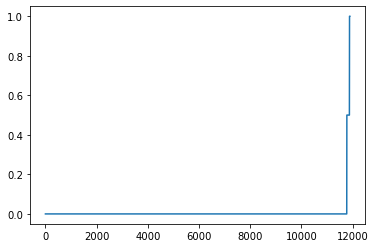

In [55]:
df22 = df_complete_under.copy()

df22['diff_Hauer'] = 1 /(df22['forecast_ssp42020'] / df22['CensusPop_20'])   # here diff refers to ratio
df22['diff_NCAR'] = 1 /(df22['population_2020_ssp4'] / df22['CensusPop_20'])

df22['w1'] = df22['diff_Hauer'] 
df22['w2'] = df22['diff_NCAR']

df22['w1'].replace(np.inf, 1, inplace =  True,)
df22['w2'].replace(np.inf, 1, inplace =  True)

df22['w3'] = df22['w1']/ 2
df22['w4'] = df22['w2']/ 2

df22['new'] = df22['w3']* df22['forecast_ssp42020'] + df22['w4'] * df22['population_2020_ssp4']
print(np.sum(np.abs(df22['new'] - df22['CensusPop_20'])) ) #/ np.sum(df_complete['CensusPop_20']))
df22['%diff'] = ((df22['CensusPop_20']-df22['new'])) /df22['CensusPop_20']
df22['diff'] = ((df22['CensusPop_20']-df22['new']))

df22['%diff'].sort_values().reset_index(drop=True).plot()

5.674145597822644e-10


<AxesSubplot:>

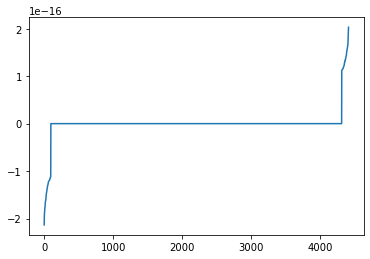

In [56]:
df33 = df_complete_over.copy()

df33['diff_Hauer'] = 1 /(df33['forecast_ssp42020'] / df33['CensusPop_20'])
df33['diff_NCAR'] = 1 /(df33['population_2020_ssp4'] / df33['CensusPop_20'])

df33['w1'] = df33['diff_Hauer'] 
df33['w2'] = df33['diff_NCAR']

df33['w1'].replace(np.inf, 1, inplace =  True,)
df33['w2'].replace(np.inf, 1, inplace =  True)

df33['w3'] = df33['w1']/ 2
df33['w4'] = df33['w2']/ 2

df33['new'] = df33['w3']* df33['forecast_ssp42020'] + df33['w4'] * df33['population_2020_ssp4']
print(np.sum(np.abs(df33['new'] - df33['CensusPop_20'])) ) #/ np.sum(df_complete['CensusPop_20']))
df33['%diff'] = ((df33['CensusPop_20']-df33['new'])) /df33['CensusPop_20']
df33['diff'] = ((df33['CensusPop_20']-df33['new']))

df33['%diff'].sort_values().reset_index(drop=True).plot()

In [57]:
df11.shape, df22.shape, df33.shape

((15269, 265), (11889, 265), (4410, 265))

In [58]:
df_with_weights = pd.concat([df11, df22, df33], axis =0).reset_index(drop=True)

In [59]:
df_with_weights[['NAME', 'CensusPop_20', 'forecast_ssp42020', 'population_2020_ssp4', 'new', 'w3', 'w4']]

,NAME,CensusPop_20,forecast_ssp42020,population_2020_ssp4,new,w3,w4
0,"Abbeville city, Alabama",2358.0,2353.0,3069.796387,2358.0,0.993025,0.006975
1,"Adamsville city, Alabama",4366.0,4288.0,6658.815430,4366.0,0.967100,0.032900
2,"Akron town, Alabama",225.0,219.0,225.859894,225.0,0.125351,0.874649
3,"Aliceville city, Alabama",2177.0,2530.0,1369.479614,2177.0,0.695826,0.304174
4,"Altoona town, Alabama",948.0,929.0,1111.619629,948.0,0.895959,0.104041
...,...,...,...,...,...,...,...
31563,"Veteran CDP, Wyoming",21.0,23.0,38.477558,21.0,0.456522,0.272886
31564,"Vista West CDP, Wyoming",940.0,1055.0,959.283142,940.0,0.445498,0.489949
31565,"Warren AFB CDP, Wyoming",2863.0,2934.0,4206.195801,2863.0,0.487900,0.340331
31566,"Westview Circle CDP, Wyoming",41.0,42.0,199.810654,41.0,0.488095,0.102597


In [60]:
# # Normalized Forecast Metric to measure the forecast bias 
# df_complete['w1'] = 1 - ((df_complete['forecast_ssp42020'] - df_complete['CensusPop_20']) / (df_complete['forecast_ssp42020'] + df_complete['CensusPop_20']))
# df_complete['w2'] = 1 - ((df_complete['sum2020_SSP_4'] - df_complete['CensusPop_20']) / (df_complete['sum2020_SSP_5'] + df_complete['CensusPop_20']))

In [61]:
# CITIES WITH NO FORECASTED DATA
# df_complete[df_complete['%diff'] ==1][['GEOID', 'NAME', 'w1', 'w2','w3', 'w4',
#              'forecast_ssp42020','population_2020_ssp4','CensusPop_20', 'new', '%diff']].sort_values(by = ['%diff'])

<AxesSubplot:>

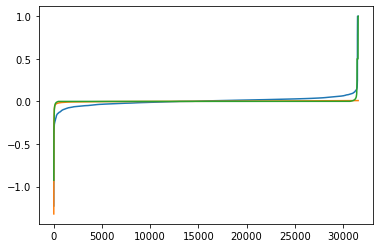

In [62]:
df_complete.shape
((df_complete['CensusPop_20'] - df_complete['forecast_ssp42020'])/ df_complete['CensusPop_20']).sort_values().reset_index(drop=True).plot() 
((df_complete['CensusPop_20'] - df_complete['population_2020_ssp4'])/ df_complete['CensusPop_20']/100).sort_values().reset_index(drop=True).plot() 
df_with_weights['%diff'].sort_values().reset_index(drop=True).plot() # [df_complete['%diff'] !=1]

In [63]:
'''
ALthough in close timeline forecast based on recent values align, over time they may fluctuate
'''

'\nALthough in close timeline forecast based on recent values align, over time they may fluctuate\n'

In [64]:
# forecasted_df = combined_df.reset_index().copy()
# forecasted_df
df_with_weights.columns

Index(['GEOID', 'CensusPop_20', 'forecast_ssp12020', 'forecast_ssp22020',
       'forecast_ssp32020', 'forecast_ssp42020', 'forecast_ssp52020',
       'forecast_ssp12025', 'forecast_ssp22025', 'forecast_ssp32025',
       ...
       '%diff_Hauer', '%diff_NCAR', 'diff_Hauer', 'diff_NCAR', 'w1', 'w2',
       'w3', 'w4', 'new', '%diff'],
      dtype='object', length=265)

In [65]:
df_w3 = df_with_weights.filter(regex= 'forecast').multiply(df_with_weights['w3'], axis="index")
df_w3.columns = df_w3.columns.str.split('_').str[1]
df_w4 = df_with_weights.filter(regex= 'population').multiply(df_with_weights['w4'], axis="index")
df_w4.columns = df_w4.columns.str.split('population_').str[1]

In [66]:
df_w4.columns = ['ssp12010', 'ssp12020', 'ssp12030', 'ssp12040', 'ssp12050',
                 'ssp12060', 'ssp12070', 'ssp12080', 'ssp12090', 'ssp12100',
                 'ssp22010', 'ssp22020', 'ssp22030', 'ssp22040', 'ssp22050',
                 'ssp22060', 'ssp22070', 'ssp22080', 'ssp22090', 'ssp22100',
                 'ssp32010', 'ssp32020', 'ssp32030', 'ssp32040', 'ssp32050',
                 'ssp32060', 'ssp32070', 'ssp32080', 'ssp32090', 'ssp32100',
                 'ssp42010', 'ssp42020', 'ssp42030', 'ssp42040', 'ssp42050',
                 'ssp42060', 'ssp42070', 'ssp42080', 'ssp42090', 'ssp42100',
                 'ssp52010', 'ssp52020', 'ssp52030', 'ssp52040', 'ssp52050',
                 'ssp52060', 'ssp52070', 'ssp52080', 'ssp52090', 'ssp52100']

In [67]:
df_2020 = df_w3.filter(regex='2020') + df_w4.filter(regex='2020')
df_2030 = df_w3.filter(regex='2030') + df_w4.filter(regex='2030')
df_2040 = df_w3.filter(regex='2040') + df_w4.filter(regex='2040')
df_2050 = df_w3.filter(regex='2050') + df_w4.filter(regex='2050')
df_2060 = df_w3.filter(regex='2060') + df_w4.filter(regex='2060')
df_2070 = df_w3.filter(regex='2070') + df_w4.filter(regex='2070')
df_2080 = df_w3.filter(regex='2080') + df_w4.filter(regex='2080')
df_2090 = df_w3.filter(regex='2090') + df_w4.filter(regex='2090')
df_2100 = df_w3.filter(regex='2100') + df_w4.filter(regex='2100')

In [68]:
# merging weighted summed datasets

In [69]:
df_for_forecast = pd.concat([df_2020, df_2030, df_2040, df_2050, df_2060, 
                             df_2070, df_2080, df_2090, df_2100, df_with_weights[['GEOID']]], axis =1)

In [70]:
forecasted_df = df_for_forecast.copy()
len(forecasted_df.filter(regex='ssp2').columns)

9

In [71]:
forecasted_df['find_trend_ssp1'] = forecasted_df[forecasted_df.filter(regex='ssp1').columns].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp2'] = forecasted_df[forecasted_df.filter(regex='ssp2').columns].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp3'] = forecasted_df[forecasted_df.filter(regex='ssp3').columns].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp4'] = forecasted_df[forecasted_df.filter(regex='ssp4').columns].astype(str).fillna('').apply(', '.join, axis=1)
forecasted_df['find_trend_ssp5'] = forecasted_df[forecasted_df.filter(regex='ssp5').columns].astype(str).fillna('').apply(', '.join, axis=1)

In [72]:
import pymannkendall as mk
import numpy as np
test_res = []

column_name = ['find_trend_ssp1','find_trend_ssp2', 'find_trend_ssp3', 'find_trend_ssp4', 'find_trend_ssp5']

for i in range(0,len(column_name)):
    for j in range(0,len(forecasted_df[column_name])):
        test_res.append(mk.original_test(np.asarray([float(k) for k in forecasted_df.iloc[j][column_name[i]].split(',')]), alpha=0.05))  

for i in range(0,len(column_name)):
    new_col_name = 'result' + column_name[i][10:]
    forecasted_df[new_col_name] =  test_res[(i*len(forecasted_df)):(i+1)*len(forecasted_df)]

In [73]:
forecasted_df['future trend from SSP 1'] = ''
forecasted_df['future trend from SSP 2'] = ''
forecasted_df['future trend from SSP 3'] = ''
forecasted_df['future trend from SSP 4'] = ''
forecasted_df['future trend from SSP 5'] = ''

In [74]:
for i in range(len(forecasted_df)):
    forecasted_df['future trend from SSP 1'][i] = forecasted_df['result_ssp1'][i][0]
    forecasted_df['future trend from SSP 2'][i] = forecasted_df['result_ssp2'][i][0]
    forecasted_df['future trend from SSP 3'][i] = forecasted_df['result_ssp3'][i][0]
    forecasted_df['future trend from SSP 4'][i] = forecasted_df['result_ssp4'][i][0]
    forecasted_df['future trend from SSP 5'][i] = forecasted_df['result_ssp5'][i][0]

C:\Users\uttar\AppData\Local\Temp\ipykernel_7944\2303076067.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecasted_df['future trend from SSP 1'][i] = forecasted_df['result_ssp1'][i][0]
C:\Users\uttar\AppData\Local\Temp\ipykernel_7944\2303076067.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forecasted_df['future trend from SSP 2'][i] = forecasted_df['result_ssp2'][i][0]
C:\Users\uttar\AppData\Local\Temp\ipykernel_7944\2303076067.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [75]:
# forecasted_df.columns

In [76]:
forecasted_df.columns

Index(['ssp12020', 'ssp22020', 'ssp32020', 'ssp42020', 'ssp52020', 'ssp12030',
       'ssp22030', 'ssp32030', 'ssp42030', 'ssp52030', 'ssp12040', 'ssp22040',
       'ssp32040', 'ssp42040', 'ssp52040', 'ssp12050', 'ssp22050', 'ssp32050',
       'ssp42050', 'ssp52050', 'ssp12060', 'ssp22060', 'ssp32060', 'ssp42060',
       'ssp52060', 'ssp12070', 'ssp22070', 'ssp32070', 'ssp42070', 'ssp52070',
       'ssp12080', 'ssp22080', 'ssp32080', 'ssp42080', 'ssp52080', 'ssp12090',
       'ssp22090', 'ssp32090', 'ssp42090', 'ssp52090', 'ssp12100', 'ssp22100',
       'ssp32100', 'ssp42100', 'ssp52100', 'GEOID', 'find_trend_ssp1',
       'find_trend_ssp2', 'find_trend_ssp3', 'find_trend_ssp4',
       'find_trend_ssp5', 'result_ssp1', 'result_ssp2', 'result_ssp3',
       'result_ssp4', 'result_ssp5', 'future trend from SSP 1',
       'future trend from SSP 2', 'future trend from SSP 3',
       'future trend from SSP 4', 'future trend from SSP 5'],
      dtype='object')

In [77]:
# =========== DEFINING df for use rest of the section
# joining table data with spatial data
df = places_merged.merge(forecasted_df, left_on='GEOID', right_on='GEOID', how = 'left')

In [79]:
df[['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 'future trend from SSP 4',
    'future trend from SSP 5']].apply(pd.Series.value_counts)/ df['future trend from SSP 2'].value_counts().sum()

,future trend from SSP 1,future trend from SSP 2,future trend from SSP 3,future trend from SSP 4,future trend from SSP 5
decreasing,0.468798,0.498353,0.846490,0.644830,0.105423
increasing,0.408673,0.400215,0.035922,0.181323,0.843702
no trend,0.122529,0.101432,0.117587,0.173847,0.050874


In [80]:
df['future trend from SSP 2'].value_counts().sum(), df.shape
df[['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 'future trend from SSP 4', 'future trend from SSP 5']].count()

future trend from SSP 1    31568
future trend from SSP 2    31568
future trend from SSP 3    31568
future trend from SSP 4    31568
future trend from SSP 5    31568
dtype: int64

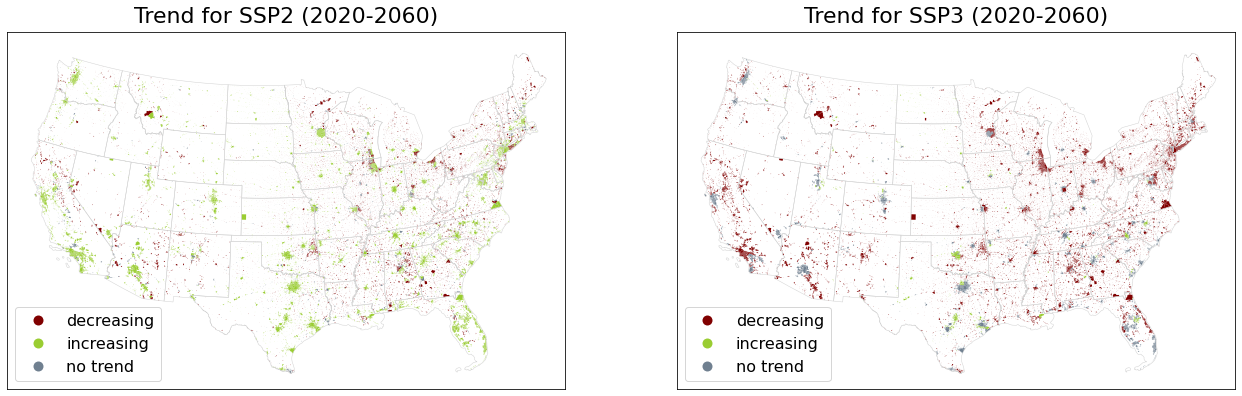

In [81]:
df = df.to_crs('EPSG:9311')
#US_states = US_states.to_crs('EPSG:9311')
columns = ['future trend from SSP 2', 'future trend from SSP 3'] 
colors = ['maroon','yellowgreen','slategray']
title_dict = {'trend':'Trend from ACS data 2010-2020', 'future trend from SSP 1':'Trend for SSP1 (2020-2060)', 
              'future trend from SSP 2':'Trend for SSP2 (2020-2060)', 'future trend from SSP 3': 'Trend for SSP3 (2020-2060)',
              'future trend from SSP 4': 'Trend for SSP4 (2020-2060)', 'future trend from SSP 5':'Trend for SSP5 (2020-2060)'}

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22,12))

for ax,col in zip(ax.flatten(), columns):
    xlim = ([-2257388.37, 2695859.75]) 
    ylim = ([-2246944.04, 918095.9])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    cmap_colors = matplotlib.colors.ListedColormap(colors)
    base = US_states.boundary.plot(ax =ax, edgecolor = 'lightgray', linewidth = 0.5)
    df.plot(ax =ax, column = col, cmap=cmap_colors, legend = True, legend_kwds={'loc': 'lower left','fontsize': 16, })
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax.set_title(title_dict.get(col), fontsize=22, pad=10)

fig.savefig(r'D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\forecast trend output\Figures\All Trends from forecast.png', dpi = 900)

In [82]:
# #df.groupby(['label'])['expected_trend_3'].count()
# # df['label'] / df.groupby(['label'])['expected_trend_3'].transform('sum')

# df.groupby(['expected_trend_2', 'label', ]).agg({'label': 'count'}).groupby(level=0).apply(lambda x: (100 * x / float(x.sum())).round(2)).plot()
# df.groupby(['expected_trend_3', 'label', ]).agg({'label': 'count'}).groupby(level=0).apply(lambda x: (100 * x / float(x.sum())).round(2)).plot()
# df[df['expected_trend_3'].isnull()]['STATEFP'].unique()
# # missing values in Alaska and South Dakota
# # df.shape

In [83]:
# df.shape, df_not_null.shape
# df['diff'] = (df['P_20']- df['forecast_ssp32020'])/df['P_20']

In [84]:
# df

In [85]:
# df[~df['diff'].notnull()][['STATEFP','NAMELSAD', 'NAME10', 'P_19', 'P_20_upper', 'P_20_lower', 'P_20','forecast_ssp32020','forecast_ssp42020', 'diff', 
#                              'label','expected_trend_3',]].sort_values('diff')

In [86]:
df[(df['ssp32020'] ==0) & (df['ssp32040'] ==0)]['future trend from SSP 3'].value_counts()
# df.shape[0]-251, 32188-28744

no trend    15
Name: future trend from SSP 3, dtype: int64

In [87]:
df['density_km2'] = df['CensusPop_20'] *1000*1000 / df['ALAND']
# df[df['density_km2'] == 0][df[df['density_km2'] == 0]['NAMELSAD'].str.contains('CDP')==False][['Pop_estimate', 'P_19', 'P_20']]

In [88]:
# df[df['density_km2'] != 0].groupby('future trend from SSP 2')['density_km2'].describe().round(2)

In [89]:
df.groupby(['future trend from SSP 2'])['density_km2'].describe().round(1)
# df.columns

,count,mean,std,min,25%,50%,75%,max
future trend from SSP 2,,,,,,,,
decreasing,15732.0,290.3,331.1,0.0,78.7,196.4,387.1,5142.2
increasing,12634.0,734.7,1034.7,0.0,158.0,426.1,936.0,35050.5
no trend,3202.0,427.6,510.6,0.0,99.5,275.0,557.5,5253.1


In [90]:
df.groupby(['label'])['density_km2'].describe().round(0)

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
1 severely depopulating,954.0,162.0,319.0,0.0,25.0,68.0,170.0,3728.0
2 moderately depopulating,1797.0,274.0,426.0,0.0,82.0,171.0,335.0,10857.0
3 slowly depopulating,8904.0,495.0,727.0,0.0,126.0,309.0,588.0,35051.0
4 fluctuating,1461.0,316.0,436.0,0.0,81.0,188.0,389.0,5056.0
5 slowly increasing,5602.0,793.0,1040.0,0.0,235.0,474.0,996.0,24039.0
6 moderately increasing,7260.0,506.0,702.0,0.0,138.0,310.0,617.0,18659.0
7 highly increasing,2991.0,281.0,455.0,0.0,45.0,133.0,322.0,5755.0


In [91]:
df[df['density_km2'] != 0].groupby('label')['density_km2'].describe().round(2)


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
1 severely depopulating,954.0,162.38,318.96,0.02,25.39,68.33,169.62,3728.29
2 moderately depopulating,1797.0,273.54,425.64,0.02,81.92,171.27,335.34,10856.81
3 slowly depopulating,8904.0,494.85,727.11,0.00,126.36,309.06,587.99,35050.55
4 fluctuating,1461.0,315.95,435.75,0.04,81.21,188.09,389.37,5056.25
5 slowly increasing,5602.0,792.99,1040.13,0.13,235.08,474.08,995.62,24038.52
6 moderately increasing,7260.0,506.03,702.45,0.01,137.66,310.11,617.46,18659.18
7 highly increasing,2991.0,280.81,455.15,0.05,45.19,133.12,321.61,5755.05


In [92]:
df[df['density_km2'] != 0].groupby('future trend from SSP 1')['density_km2'].describe().round(2)


,count,mean,std,min,25%,50%,75%,max
future trend from SSP 1,,,,,,,,
decreasing,14799.0,284.01,322.36,0.00,77.43,193.82,379.63,5142.17
increasing,12901.0,729.40,1027.70,0.02,155.69,422.84,930.36,35050.55
no trend,3868.0,415.15,489.66,0.00,99.85,272.38,541.78,5253.10


In [93]:
df[df['density_km2'] != 0].groupby('future trend from SSP 2')['density_km2'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
future trend from SSP 2,,,,,,,,
decreasing,15732.0,290.32,331.05,0.00,78.71,196.45,387.13,5142.17
increasing,12634.0,734.70,1034.66,0.02,158.03,426.10,936.00,35050.55
no trend,3202.0,427.65,510.57,0.00,99.46,275.02,557.47,5253.10


In [94]:
df[df['density_km2'] != 0].groupby('future trend from SSP 4')['density_km2'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
future trend from SSP 4,,,,,,,,
decreasing,20356.0,321.82,389.83,0.00,83.47,211.02,420.09,8704.41
increasing,5724.0,726.53,1116.06,0.02,156.65,439.70,935.20,35050.55
no trend,5488.0,821.64,1024.34,0.00,172.91,475.44,1103.56,12333.73


<AxesSubplot:xlabel='Expected Trend', ylabel='No of cities'>

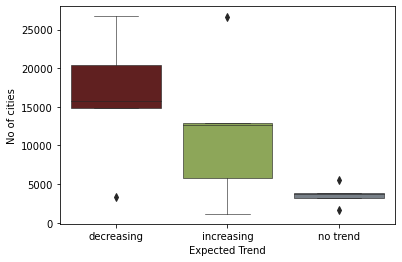

In [95]:
trend_sce_df = pd.DataFrame()
trend_sce_df['SSP 1'] = df['future trend from SSP 1'].value_counts()
trend_sce_df['SSP 2'] = df['future trend from SSP 2'].value_counts()
trend_sce_df['SSP 3'] = df['future trend from SSP 3'].value_counts()
trend_sce_df['SSP 4'] = df['future trend from SSP 4'].value_counts()
trend_sce_df['SSP 5'] = df['future trend from SSP 5'].value_counts()

import seaborn as sns
sns.boxplot(x="Expected Trend", y="No of cities", 
            data=pd.melt(trend_sce_df.T, var_name='Expected Trend', value_name='No of cities', col_level=None, ignore_index=False),
            palette = ['maroon','yellowgreen','slategray'],
            saturation=0.5,
            linewidth=0.6,
           )

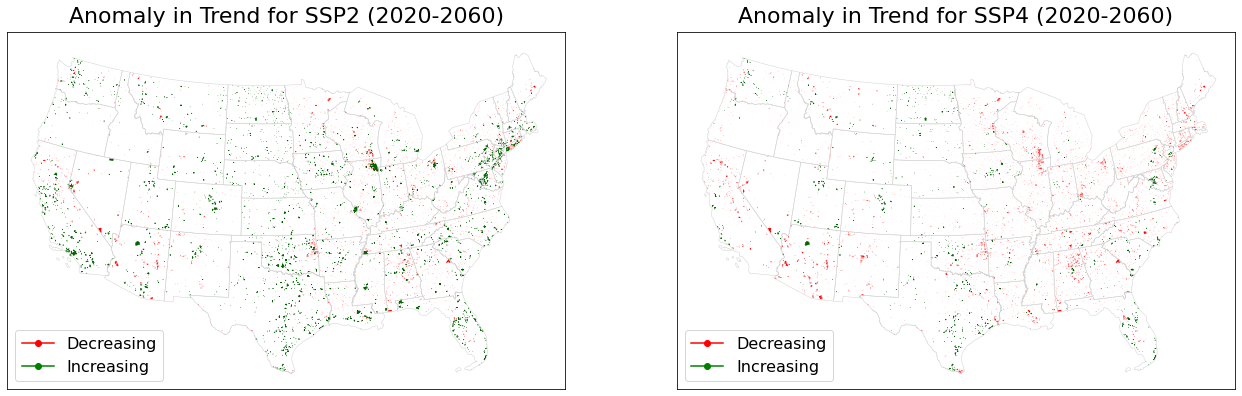

In [96]:
from matplotlib import lines
#US_states = US_states.to_crs('EPSG:9311')
columns = ['future trend from SSP 2', 'future trend from SSP 4'] 
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(22,12))

for ax,col in zip(ax.flatten(), columns):
    xlim = ([-2257388.37, 2695859.75]) 
    ylim = ([-2246944.04, 918095.9])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    cmap_colors = matplotlib.colors.ListedColormap(colors)
    base = US_states.boundary.plot(ax =ax, edgecolor = 'lightgray', linewidth = 0.5)
    df[(df[col] == 'increasing') & (df['label'].str.contains('depopulating'))].plot(ax =ax, color = 'darkgreen', 
                                                                                                   edgecolor = 'darkgreen', 
                                                                                                   linewidth = 0.4, legend = True, 
                                                                                                   legend_kwds={'loc': 'lower left','fontsize': 16})
    df[(df[col] == 'decreasing') & (df['label'].str.contains('increasing'))].plot(ax =ax, color = 'red', legend = True, 
                                                                                                   legend_kwds={'loc': 'lower left','fontsize': 16})
    ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
    ax.set_title('Anomaly in ' + title_dict.get(col), fontsize=22, pad=10)
    ax.legend([lines.Line2D([0], [0], marker='o', ls='solid', c='red'),
               lines.Line2D([0], [0], marker='o',ls='solid', c='green'),],
              ['Decreasing', 'Increasing'],
              loc = 'lower left', fontsize = 16)

fig.savefig(r'D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\forecast trend output\Figures\Anomaly in trend_current_forecast.png', dpi = 300)

In [97]:
df[df['density_km2'] != 0]['density_km2'].min()

0.003232994838342693

In [98]:
# df['diff'].min()

In [99]:
# df[df['density_km2'] != 0].shape[0] , df[df['density_km2'] == 0].shape[0]

In [100]:
# create figure and axis objects with subplots()

# fig,ax=plt.subplots(figsize=(14,5))
# # df['diff'].plot(ax=ax, alpha = 0.8, label = 'Difference')
# ax.set_ylim(-1.5, 0.35)
# ax.set_ylabel("Difference",fontsize=14)
# ax.set_title('Difference in estimation and projection in 2020 with density', fontsize=14)
# # twin object for two different y-axis on the sample plot
# ax2=ax.twinx()
# df[df['density_km2'] != 0]['density_km2'].plot(ax=ax2, color="goldenrod", alpha = 0.8, label = 'Density')
# ax2.set_ylabel("Density_km2",fontsize=14, )
# ax2.set_ylim(-1000, 37000)

# ax.legend([lines.Line2D([0], [0], ls='solid', c='steelblue'),
#            lines.Line2D([0], [0], ls='solid', c='goldenrod'),],
#               ['Difference', 'Density'],
#               loc = 'center left', fontsize = 12)

# plt.show()

In [101]:
from datetime import date

today = date.today()

file_name = 'forecasted_trend_' + str(date.today())
# df.to_csv(r'D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\forecast trend output\\' + file_name + '.csv')

In [102]:
'''
Not everyone resides in a place; in 1990, approximately 66 million people (26 percent) in the United States lived outside of any place, 
either in small settlements, in the open countryside, or in the densely settled fringe of large cities in areas that were built-up, 
but not identifiable as places. 

'''

'\nNot everyone resides in a place; in 1990, approximately 66 million people (26 percent) in the United States lived outside of any place, \neither in small settlements, in the open countryside, or in the densely settled fringe of large cities in areas that were built-up, \nbut not identifiable as places. \n\n'

In [103]:
county_Projection[['ssp32020', 'ssp32040', 
                   'ssp32050', 'ssp32060']].sum(), forecasted_df[['ssp32020', 'ssp32040', 'ssp32050', 'ssp32060', ]].sum()
# 245375572.0/3.287417e+08, 256977104.0/3.388857e+08, 255146017.0/3.342000e+08, 250260502.0/3.260763e+08

(ssp32020    3.287505e+08
 ssp32040    3.388928e+08
 ssp32050    3.342065e+08
 ssp32060    3.260822e+08
 dtype: float64,
 ssp32020    2.459643e+08
 ssp32040    2.579399e+08
 ssp32050    2.564151e+08
 ssp32060    2.518757e+08
 dtype: float64)

In [104]:
# forecasted_df.columns[20:]
df.columns[10:]

Index(['MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry', 'CensusPop_20', 'Pop_estimate', 'P_19', 'P_20', 'trend',
       'label', 'State', '_merge', 'ssp12020', 'ssp22020', 'ssp32020',
       'ssp42020', 'ssp52020', 'ssp12030', 'ssp22030', 'ssp32030', 'ssp42030',
       'ssp52030', 'ssp12040', 'ssp22040', 'ssp32040', 'ssp42040', 'ssp52040',
       'ssp12050', 'ssp22050', 'ssp32050', 'ssp42050', 'ssp52050', 'ssp12060',
       'ssp22060', 'ssp32060', 'ssp42060', 'ssp52060', 'ssp12070', 'ssp22070',
       'ssp32070', 'ssp42070', 'ssp52070', 'ssp12080', 'ssp22080', 'ssp32080',
       'ssp42080', 'ssp52080', 'ssp12090', 'ssp22090', 'ssp32090', 'ssp42090',
       'ssp52090', 'ssp12100', 'ssp22100', 'ssp32100', 'ssp42100', 'ssp52100',
       'find_trend_ssp1', 'find_trend_ssp2', 'find_trend_ssp3',
       'find_trend_ssp4', 'find_trend_ssp5', 'result_ssp1', 'result_ssp2',
       'result_ssp3', 'result_ssp4', 'result_ssp5', 'future trend from SSP 1',
       'fut

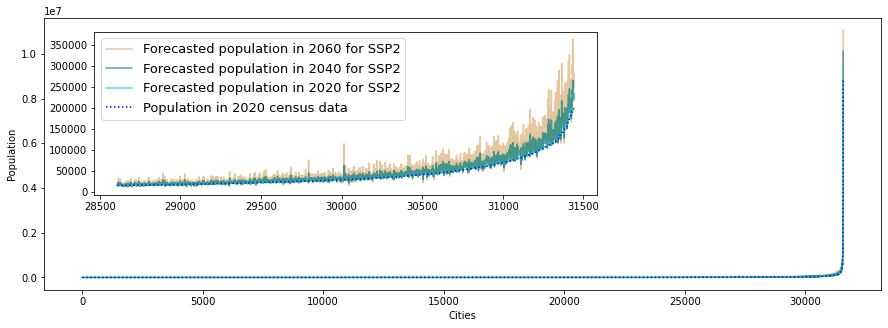

In [105]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df_main = df.sort_values('CensusPop_20').reset_index()
df_inset= df_main[(df_main['ssp22020'] < 200000) & (df_main['CensusPop_20'] > 15000)]

fig, ax = plt.subplots(1, 1, figsize=[15, 5])
ax.plot(df_main.index, df_main['ssp22060'], "burlywood", alpha = 0.8, label = 'forecasted population 2060 for SSP2');
ax.plot(df_main.index, df_main['ssp22040'],"teal", alpha = 0.7, label = 'forecasted population 2040 for SSP2');
ax.plot(df_main.index, df_main['ssp22020'], "darkturquoise", alpha = 0.7, label = 'forecasted population 2020 for SSP2');
ax.plot(df_main.index, (df_main['CensusPop_20']), "b",linestyle='dotted', linewidth=1.5, label = 'Population in 2020 census data')

# ax.fill_between(df_main.index, df_main['P_20_upper'], df_main['P_20_lower'], color="grey", alpha=0.5);

# Create inset of mixed specifications in the second subplot;
# width is 30% of parent axes' bounding box and
# height is 1 inch at the upper left corner (loc=2)
#Get artists and labels for legend and chose which ones to display

ax1 = ax.inset_axes((0.06,0.35,.6,.6)) #inset_axes(ax, width="50%", height=2, loc=2, borderpad=5)

ax1.plot(df_inset.index, df_inset['ssp22060'], "burlywood", alpha = 0.8, label = 'Forecasted population in 2060 for SSP2');
ax1.plot(df_inset.index, df_inset['ssp42040'],"teal", alpha = 0.7, label = 'Forecasted population in 2040 for SSP2');
ax1.plot(df_inset.index, df_inset['ssp22020'], "darkturquoise", alpha = 0.7, label = 'Forecasted population in 2020 for SSP2');
ax1.plot(df_inset.index, (df_inset['CensusPop_20']), "b",linestyle='dotted', linewidth=1.5, label = 'Population in 2020 census data')

# ax1.fill_between(df_inset.index, df_inset['P_20_upper'], df_inset['P_20_lower'], color="grey", alpha=0.5);

display = (0,1,2,3,4)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend([handle for i,handle in enumerate(handles) if i in display],
           [label for i,label in enumerate(labels) if i in display], loc = 'best', fontsize = 13)


# Turn ticklabels of insets off
for axi in [ax, ax1]:
    axi.tick_params(labelleft=True, labelbottom=True)
ax.set_xlabel('Cities')
ax.set_ylabel('Population')
plt.show()

fig.savefig(r'D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\forecast trend output\Figures\Plot variation in estimation and projected values.png', dpi = 300,
           bbox_inches='tight', transparent="True", pad_inches=0)

In [106]:
# county_Projection.crs, places_merged.crs
# df.columns

In [107]:
# # import the United States shape file
# # set state code as index, exclude states that we will never display
# gdf = df.set_index('STATEFP') #.drop(index=['02', 'VI', 'MP', 'GU', 'AS'])
# colors = ['red','darkgreen','goldenrod']

# column_name = "future trend from SSP 2"
# # create an axis with 2 insets − this defines the inset sizes
# fig, continental_ax = plt.subplots(figsize=(20, 20))
# alaska_ax = continental_ax.inset_axes([.01, .01, .28, .30])
# hawaii_ax = continental_ax.inset_axes([.20, .01, .25, .25])

# # Set bounds to fit desired areas in each plot
# continental_ax.set_xlim(-2257388.37, 2695859.75)
# continental_ax.set_ylim(-2546944.04, 808080.9)
# #[-8532676.07614065, -3748050.80000724,  3754325.60307967, 4852777.56870515]
# alaska_ax.set_xlim(-4383115.86156959, -1515327.22537998)
# alaska_ax.set_ylim(1458524.37417163, 3919523.37426209)

# hawaii_ax.set_xlim(-5722090.887043, -5462538.83170424)   # bounds found for only populated places in Hawaii
# hawaii_ax.set_ylim(-1044618.58269969, -455238.37803499)
# #[-6440340.62278472, -1056683.73964088, -5453622.10058784, 1580494.49019997] # total bounds for Hawaii

# # Plot the data per area - requires passing the same choropleth parameters to each call
# # because different data is used in each call, so automatically setting bounds won’t work
# #vmin, vmax = df['ALAND'].agg(['min', 'max'])
# US_states.plot(ax=continental_ax, facecolor = 'none', edgecolor='gray', linewidth=0.4)
# gdf.plot(column=column_name, 
#                                   ax=continental_ax,
#                                   cmap=matplotlib.colors.ListedColormap(colors), 
#                                   legend = True,
#                                   legend_kwds={'loc': 'lower right', 'fontsize': 25,}) #, vmin=vmin, vmax=vmax)

# US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.8, ax=alaska_ax)
# gdf.plot(column=column_name, cmap=matplotlib.colors.ListedColormap(colors), ax=alaska_ax) #, vmin=vmin, vmax=vmax)

# US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.8, ax=hawaii_ax)
# gdf.plot(column=column_name, cmap=matplotlib.colors.ListedColormap(colors), ax=hawaii_ax,
#                     missing_kwds = dict(color='black')) #, vmin=vmin, vmax=vmax)

# # remove ticks
# for ax in [continental_ax, alaska_ax, hawaii_ax]:
#     ax.set_yticks([])
#     ax.set_xticks([])
#     ax.axis('off')
#     plt.tight_layout()
# fig.patch.set_visible(False)
    
# # continental_ax.set_title('Population trend from population projection 2020-2100 for SSP' + column_name[-1:], fontsize=26, pad=10)
# fig.savefig(r'D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\all states trend for SSP_' + str(column_name) + '.png', dpi = 300,
#            bbox_inches='tight')

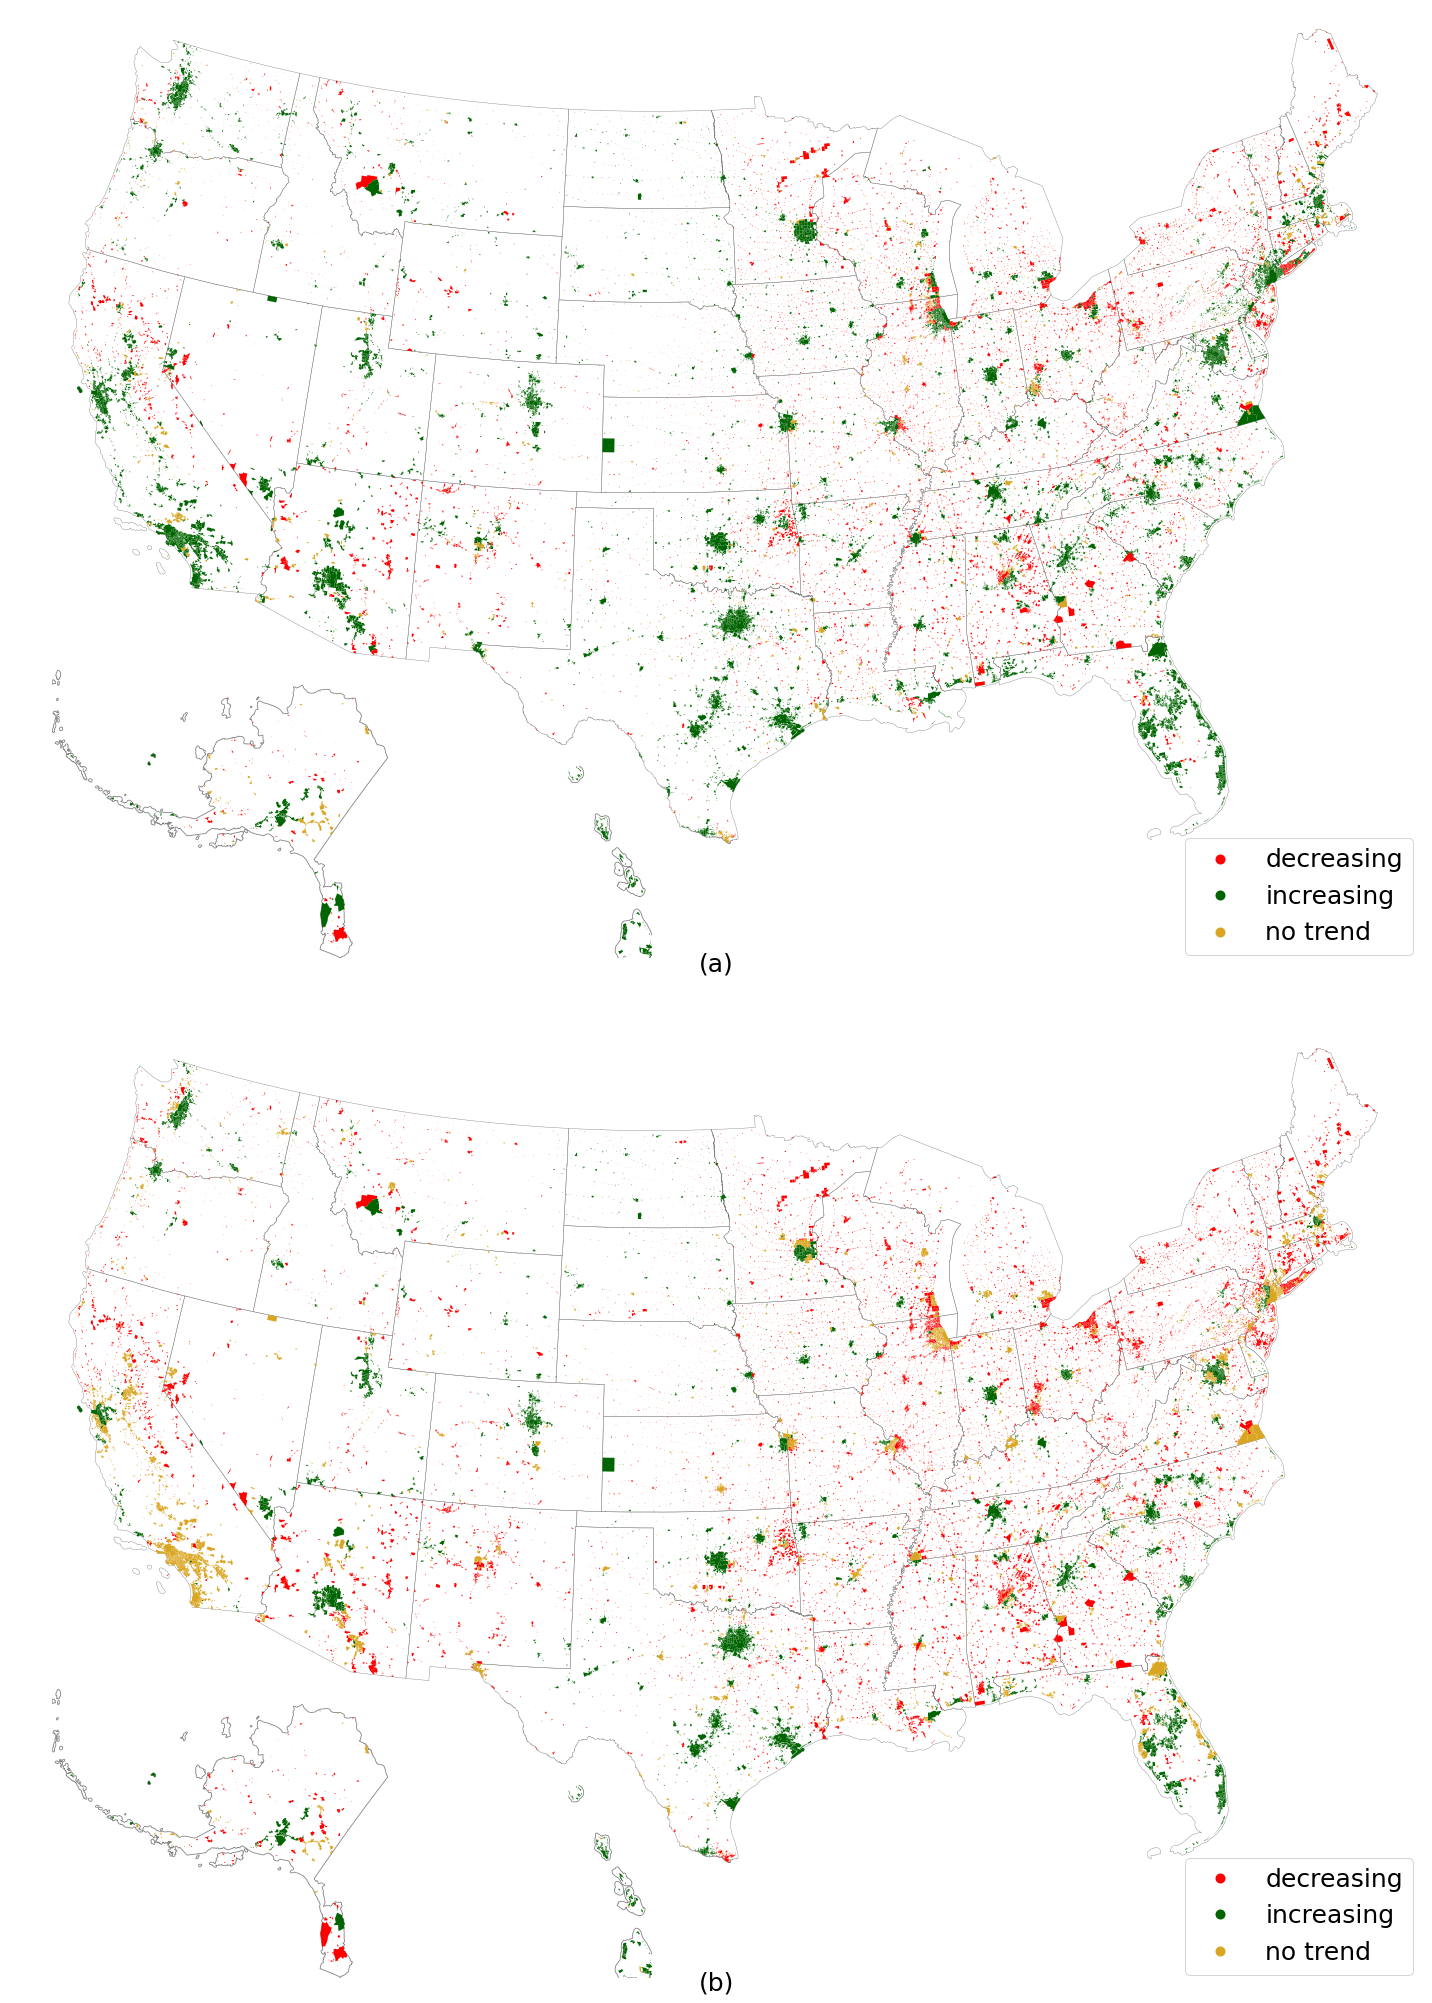

In [108]:
# import the United States shape file
# set state code as index, exclude states that we will never display
gdf = df.set_index('STATEFP') #.drop(index=['02', 'VI', 'MP', 'GU', 'AS'])
colors = ['red','darkgreen','goldenrod']

column_name = ["future trend from SSP 2", "future trend from SSP 4"]
x_labels = {"future trend from SSP 2": "(a)", 
            "future trend from SSP 4": '(b)'}


fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 40))

for ax, col in zip(axes.flatten(), column_name):
    continental_ax = ax
    alaska_ax = ax.inset_axes([.01, .01, .28, .30])
    hawaii_ax = ax.inset_axes([.30, .01, .25, .2])
               
    # Set bounds to fit desired areas in each plot
    continental_ax.set_xlim(-2257388.37, 2695859.75)
    continental_ax.set_ylim(-2546944.04, 808080.9)
    continental_ax.set_title((x_labels[col]).strip('\"'), fontsize = 25, 
                     loc='center',  y=-0.01)

    #[-8532676.07614065, -3748050.80000724,  3754325.60307967, 4852777.56870515]
    alaska_ax.set_xlim(-4383115.86156959, -1515327.22537998)
    alaska_ax.set_ylim(1458524.37417163, 3919523.37426209)

    hawaii_ax.set_xlim(-5722090.887043, -5462538.83170424)   # bounds found for only populated places in Hawaii
    hawaii_ax.set_ylim(-1044618.58269969, -455238.37803499)
               
               
    US_states.plot(ax=continental_ax, facecolor = 'none', edgecolor='gray', linewidth=0.4)
    gdf.plot(column=col, 
             ax=continental_ax,
             cmap=matplotlib.colors.ListedColormap(colors), 
             legend = True,
             legend_kwds={'loc': 'lower right', 'fontsize': 25,})

    US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.8, ax=alaska_ax)
    gdf.plot(column=col, cmap=matplotlib.colors.ListedColormap(colors), ax=alaska_ax) 

    US_states.plot(facecolor = 'none', edgecolor='gray', linewidth=0.8, ax=hawaii_ax)
    gdf.plot(column=col, cmap=matplotlib.colors.ListedColormap(colors), ax=hawaii_ax,
                    missing_kwds = dict(color='black'))

    # remove ticks
    for ax in [continental_ax, alaska_ax, hawaii_ax]:
        ax.set_yticks([])
        ax.set_xticks([])
        ax.axis('off')
        plt.tight_layout()
        plt.axis('off') 
        
fig.patch.set_visible(False)

fig.savefig(r'D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\all states trend SSP 2 and 4' + '.png', dpi = 300,
           bbox_inches='tight')

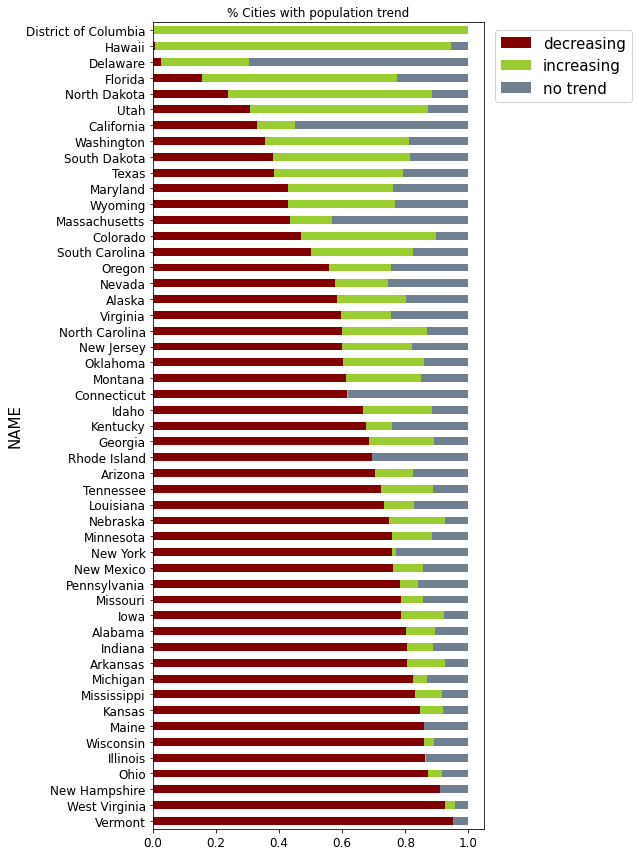

In [109]:
# get state names
state_names= US_states[['STATEFP', 'NAME']]
# Percent cities in each trend group
# pd.set_option('display.max_rows', None)

column_name = 'future trend from SSP 4'

percent_cities = (df.groupby(['STATEFP', column_name]).count()[['GEOID']] /
                  df.groupby(['STATEFP']).count()[['GEOID']]).reset_index()

table = pd.pivot_table(percent_cities, values='GEOID', index=['STATEFP'], # 'future trend from SSP 3'
                    columns=[column_name], aggfunc=np.sum).reset_index()

table = table.merge(state_names, on = 'STATEFP')
# table['sum'] = table[['1 severely depopulating', '2 moderately depopulating','3 slowly depopulating']].sum(axis =1)
table = table.sort_values('decreasing', ascending = False) 
table.drop(columns = ['STATEFP',], inplace = True)

colors = ['maroon','yellowgreen','slategray']
# colors = ['red', 'maroon', 'indianred', 'darkorange', 'limegreen','forestgreen', 'darkgreen', 'gray']
cmap=matplotlib.colors.ListedColormap(colors)

# plot a Stacked Bar Chart using matplotlib
ax = table.plot(
    x = 'NAME',
    kind = 'barh',
    stacked = True,
    cmap = cmap,
    title = '% Cities with population trend',
    mark_right = True,
    figsize=(9, 12))
# setting label sizes after creation
ax.yaxis.label.set_size(15)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(bbox_to_anchor=(1.01, 1.00), loc='upper left', prop={'size': 15})
plt.tight_layout()
plt.show()
fig = ax.get_figure()
fig.savefig(r'D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\forecast trend output\Figures\pct cities with pop trend_' + str(column_name) + '.png',
            dpi = 300)

In [110]:
# table[table['decreasing'] > 0.50].reset_index()
print('States with 50% or above no of cities with a decreasing trend for: ')

table[table['decreasing'] >0.5]['decreasing'].count()/ table['decreasing'].count()

States with 50% or above no of cities with a decreasing trend for: 


0.74

<AxesSubplot:>

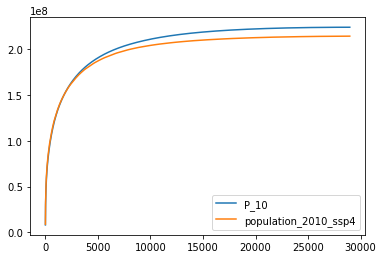

In [111]:
df['P_10'] = df['Pop_estimate'].str.split(',').str[-11].str.strip('[]').astype(float)
df['P_10'].isna().sum()

df_complete10 = df_complete.merge(df[['GEOID', 'P_10']], on = 'GEOID')

df_cumsum10 = df_complete10[['P_10','population_2010_ssp4',]].sort_values(by= 'P_10', 
                                                                          ascending = False).reset_index(drop= True)
df_cumsum10 = df_cumsum10.dropna()
df_cumsum10.cumsum().plot()


In [135]:
(df.groupby(['label'])['NAME'].count()*100/df.groupby(['label'])['NAME'].count().sum()).round(1)


label
1 severely depopulating       3.3
2 moderately depopulating     6.2
3 slowly depopulating        30.7
4 fluctuating                 5.0
5 slowly increasing          19.3
6 moderately increasing      25.1
7 highly increasing          10.3
Name: NAME, dtype: float64

In [112]:
(df.groupby(['label', 'future trend from SSP 1'])['NAME'].count()*100/df.groupby(['label'])['NAME'].count()).round(1)


label                      future trend from SSP 1
1 severely depopulating    decreasing                 60.3
                           increasing                 27.1
                           no trend                   12.6
2 moderately depopulating  decreasing                 64.7
                           increasing                 24.5
                           no trend                   10.7
3 slowly depopulating      decreasing                 57.4
                           increasing                 29.2
                           no trend                   13.4
4 fluctuating              decreasing                 56.9
                           increasing                 30.2
                           no trend                   12.9
5 slowly increasing        decreasing                 32.6
                           increasing                 54.5
                           no trend                   12.9
6 moderately increasing    decreasing                 37.2
     

In [113]:
(df.groupby(['label', 'future trend from SSP 4'])['NAME'].count()*100/df.groupby(['label', 'future trend from SSP 2'])['NAME'].count().sum()).round(1).to_frame()

NAME
label                     future trend from SSP 4      
1 severely depopulating   decreasing                2.5
                          increasing                0.4
                          no trend                  0.4
2 moderately depopulating decreasing                4.9
                          increasing                0.7
                          no trend                  0.6
3 slowly depopulating     decreasing               23.5
                          increasing                3.0
                          no trend                  4.3
4 fluctuating             decreasing                3.7
                          increasing                0.6
                          no trend                  0.7
5 slowly increasing       decreasing               10.0
                          increasing                4.0
                          no trend                  5.3
6 moderately increasing   decreasing               13.3
                          increasing                7.3
                          no trend                  4.5
7 highly increasing       decreasing                6.3
                          increasing                2.4
                          no trend                  1.6

In [114]:
(df.groupby(['future trend from SSP 1','label',])['NAME'].count()*100/df.groupby(['label'])['NAME'].count()).round(1)

future trend from SSP 1  label                    
decreasing               1 severely depopulating      60.3
                         2 moderately depopulating    64.7
                         3 slowly depopulating        57.4
                         4 fluctuating                56.9
                         5 slowly increasing          32.6
                         6 moderately increasing      37.2
                         7 highly increasing          43.4
increasing               1 severely depopulating      27.1
                         2 moderately depopulating    24.5
                         3 slowly depopulating        29.2
                         4 fluctuating                30.2
                         5 slowly increasing          54.5
                         6 moderately increasing      51.9
                         7 highly increasing          43.9
no trend                 1 severely depopulating      12.6
                         2 moderately depopulating    10.7
     

In [115]:
(df.groupby(['future trend from SSP 2','label',]).size()*100/df.groupby(['future trend from SSP 1','label',]).size().sum()).round(1)

future trend from SSP 2  label                    
decreasing               1 severely depopulating       2.0
                         2 moderately depopulating     4.1
                         3 slowly depopulating        18.7
                         4 fluctuating                 3.0
                         5 slowly increasing           6.9
                         6 moderately increasing      10.0
                         7 highly increasing           4.8
increasing               1 severely depopulating       0.9
                         2 moderately depopulating     1.5
                         3 slowly depopulating         8.8
                         4 fluctuating                 1.5
                         5 slowly increasing          10.3
                         6 moderately increasing      12.8
                         7 highly increasing           4.5
no trend                 1 severely depopulating       0.4
                         2 moderately depopulating     0.6
     

In [ ]:
# df.groupby(['future trend from SSP 2','label'])['density_km2'].describe().round(2)

In [117]:
# adding US regions to the data
# Region 1: Northeast, Region 2: Midwest, Region 3: South, Region 4: West source: wiki
df = df.merge(US_states[['REGION', 'DIVISION', 'STATEFP']], on = 'STATEFP')

In [128]:
df['STATEFP'].unique(), df['REGION'].unique()

(array(['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13',
        '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
        '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
        '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48',
        '49', '50', '51', '53', '54', '55', '56'], dtype=object),
 array(['3', '4', '1', '2'], dtype=object))

In [123]:
df.groupby(['REGION','future trend from SSP 2'])['density_km2'].describe()

count         mean          std       min  \
REGION future trend from SSP 2                                               
1      decreasing               2627.0   491.819844   523.875888  3.458897   
       increasing               1663.0  1349.518588  1667.356640  1.365161   
       no trend                  526.0   782.418117   659.852705  1.944113   
2      decreasing               6430.0   322.187167   293.752488  0.764053   
       increasing               2813.0   526.994541   551.412577  0.203625   
...                                ...          ...          ...       ...   
3      increasing               4849.0   636.143450   885.383638  0.520646   
       no trend                  951.0   299.405850   355.852131  1.861159   
4      decreasing               1979.0   150.119826   210.611332  0.003233   
       increasing               3309.0   746.701807  1021.327427  0.019661   
       no trend                  759.0   304.085536   520.188876  0.004819   

                                       25%         50%          75%  \
REGION future trend from SSP 2                                        
1      decreasing               143.950388  296.364147   651.519026   
       increasing               424.956718  884.389440  1701.900036   
       no trend                 294.317622  584.661364  1104.174071   
2      decreasing               121.307000  260.820565   442.625508   
       increasing               158.437218  380.321970   687.439426   
...                                    ...         ...          ...   
3      increasing               164.079629  388.625470   804.002425   
       no trend                  96.742502  202.436914   370.830667   
4      decreasing                18.774952   61.194914   201.512148   
       increasing                88.026641  360.099677  1067.996649   
       no trend                  26.732275  113.768759   371.685611   

                                         max  
REGION future trend from SSP 2                
1      decreasing                4103.695866  
       increasing               24038.519242  
       no trend                  4186.021005  
2      decreasing                5142.168139  
       increasing                5661.310260  
...                                      ...  
3      increasing               35050.548646  
       no trend                  4317.384001  
4      decreasing                2272.037114  
       increasing               10856.805045  
       no trend                  5119.891813  

[12 rows x 8 columns]

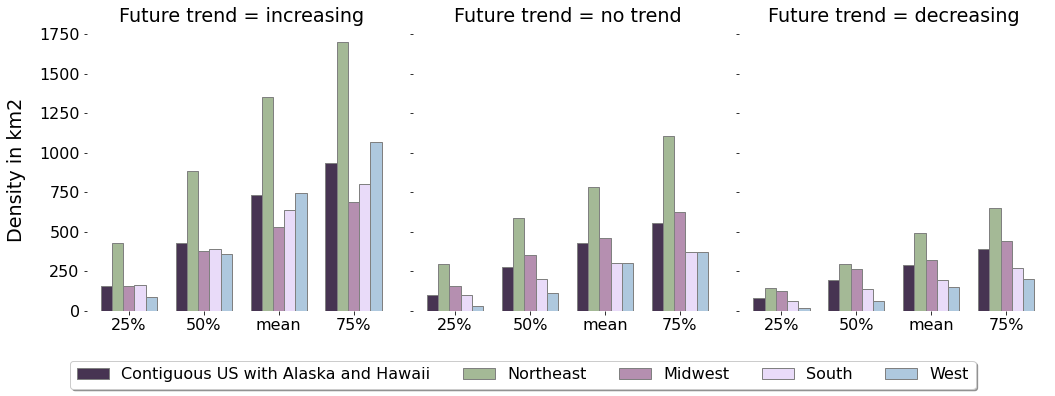

In [133]:
trend_types = ['increasing', 'no trend', 'decreasing']

df_0999 = df.groupby(['REGION','future trend from SSP 2'])['density_km2'].describe()[['25%', '50%','mean', '75%', 'max']].reset_index()
df_mainland = df.groupby(['future trend from SSP 2'])['density_km2'].describe()[['25%', '50%','mean', '75%', 'max']].reset_index()

    
fig, axes = plt.subplots(nrows=1, ncols=3, sharex='col', sharey='row', figsize=(15, 5))

for ax, trend_type in zip(axes.flatten(), trend_types):

    df_plot = pd.concat([df_0999[df_0999['future trend from SSP 2'] == trend_type], 
                    df_mainland[df_mainland['future trend from SSP 2'] == trend_type]], 
                    ignore_index = True)

    df_plot['REGION'] = df_plot['REGION'].replace({'1':'Northeast',
                                               '2':'Midwest',
                                               '3':'South',
                                               '4':'West',
                                               np.nan:'Contiguous US with Alaska and Hawaii'})


    NE = df_plot[df_plot['REGION'] =='Northeast'][['25%', '50%', 'mean', '75%']].values[0]   #[1350,425,884,1702,]
    MW = df_plot[df_plot['REGION'] =='Midwest'][['25%', '50%', 'mean', '75%']].values[0]    #[527,158,380,687,]
    S =  df_plot[df_plot['REGION'] =='South'][['25%', '50%', 'mean', '75%']].values[0]    #[636,164,389,804,]
    W =  df_plot[df_plot['REGION'] =='West'][['25%', '50%', 'mean', '75%']].values[0]    #[747,88,360,1068,]
    MS = df_plot[df_plot['REGION'] =='Contiguous US with Alaska and Hawaii'][['25%', '50%', 'mean', '75%']].values[0]   #[735,158,426,936,]

    n=len(MS)
    r = np.arange(n)
    width = .15

    ax.bar(r, MS, color = '#473452', width = width, edgecolor = 'gray', label='Contiguous US with Alaska and Hawaii',)
    ax.bar(r + width, NE, color = '#a4b996',  width = width, edgecolor = 'gray', label='Northeast',)
    ax.bar(r + 2*width, MW, color = '#b58fb0',  width = width, edgecolor = 'gray', label='Midwest',)
    ax.bar(r + 3*width, S, color = '#e9dbf9',  width = width, edgecolor = 'gray', label='South',)
    ax.bar(r + 4*width, W, color = '#aec8de',  width = width, edgecolor = 'gray', label='West',)
    
    ax.set_title("Future trend = " + str(trend_type))
    ax.set_xticks(r + 2*width,['25%','50%','mean','75%'])
    ax.set_frame_on(False)

fig.supylabel('Density in km2')
plt.rcParams['font.size'] = 16
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(-0.7, -0.15),
          fancybox=True, shadow=True, ncol=5)

plt.show()
fig.savefig(r'D:\Work\Box Sync\Depop Paper NC\Paper Draft NC\Figures\density_variation' + '.png', dpi = 300,
           bbox_inches='tight')

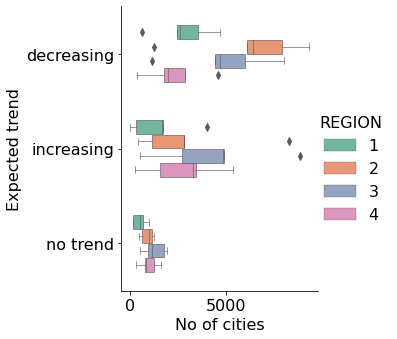

In [119]:
trend_sce_df = pd.DataFrame()
trend_sce_df['SSP 1'] = df.groupby('REGION')['future trend from SSP 1'].value_counts()
trend_sce_df['SSP 2'] = df.groupby('REGION')['future trend from SSP 2'].value_counts()
trend_sce_df['SSP 3'] = df.groupby('REGION')['future trend from SSP 3'].value_counts()
trend_sce_df['SSP 4'] = df.groupby('REGION')['future trend from SSP 4'].value_counts()
trend_sce_df['SSP 5'] = df.groupby('REGION')['future trend from SSP 5'].value_counts()
data = pd.melt(trend_sce_df, value_name='No of cities', col_level=None, ignore_index=False).reset_index()
data.rename({"future trend from SSP 1": 'Expected trend'}, axis = 1, inplace = True)

import seaborn as sns
sns.catplot(x="No of cities", y='Expected trend', 
            data=data,
            palette =sns.set_palette('Set2'),
            kind = 'box',
            hue = 'REGION',
            width = 0.6,
            # saturation=0.5,
            linewidth=0.6,
           )

In [120]:
df[['STATEFP', 'GEOID', 'NAMELSAD', 'Pop_estimate', 'P_20', 'CensusPop_20', 'trend', 'label', 'State',  
    'future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 'future trend from SSP 4', 'future trend from SSP 5', 'REGION', 
    'DIVISION']].to_csv(r'D:\Work\Box Sync\Spatial_Population_geotiff\Population from SSP\forecast trend output\future trend from SSP ' + str(date.today()) + '.csv')

In [121]:
pd.set_option('display.max_rows', 10)
plot_trend_change = df.groupby(['REGION', 'future trend from SSP 2', 'label'])['density_km2'].describe().round(2).reset_index() #count()

In [ ]:
# sns.catplot(x=plot_trend_change.index, y="mean", kind="box", data=plot_trend_change, col="REGION", hue = 'label');

In [ ]:
# sns.catplot(data = plot_trend_change, y = 'future trend from SSP 2', x = 'mean',  col="REGION", hue = 'label', kind='swarm')

In [ ]:
pd.set_option('display.max_rows', 50)
df[df['density_km2'] != 0].groupby(['REGION','label'])['density_km2'].describe().round(2)

In [ ]:
# df[df['P_20'] >100000].groupby('future trend from SSP 3')['density_km2'].describe().round(2)
pd.set_option('display.max_rows', 50)
df[df['density_km2'] != 0].groupby(['REGION', 'future trend from SSP 4', ])['density_km2'].describe().round(2).sum()

In [ ]:
# df[df['P_20'] >100000].groupby('future trend from SSP 3')['density_km2'].describe().round(2)
pd.set_option('display.max_rows', 50)
df[df['density_km2'] != 0].groupby(['REGION', 'future trend from SSP 4', ])['density_km2'].describe().round(2)

In [ ]:
df[(df['P_20'] >100000) & (df['PCICBSA']=='N')]['P_20']
# EPSG:3857
df_buffer = gpd.GeoDataFrame(df[df['P_20'] >100000]['geometry'].buffer(25000, cap_style=1, join_style=1)).reset_index()
df_buffer = df_buffer.rename({0:'geometry'}, axis=1)
df_buffer
buffer_circles = gpd.overlay(df_buffer, df_buffer, how='union')
buffer2 = gpd.overlay(buffer_circles, buffer_circles, how='union')

In [ ]:
# df.columns
# USE WEIGHTED HOUSING UNIT DENSITY AND RECHECK
# ***************************************************

In [ ]:
# df[df['P_20']>500000][['STATEFP', 'NAMELSAD', 'density_km2', 'P_20']].sort_values('P_20').tail(10)

In [ ]:
df[['P_19', 'P_20']].sum(), places_attr[['P_20', 'DP05_0001E_19', 'DP05_0001E_20']].sum()
# 244619308.0 - 242801094.0

In [ ]:
(df[['future trend from SSP 1', 'future trend from SSP 2', 'future trend from SSP 3', 
    'future trend from SSP 4', 'future trend from SSP 5']].apply(pd.Series.value_counts)/df[['future trend from SSP 1', 'future trend from SSP 2', 
    'future trend from SSP 3', 'future trend from SSP 4','future trend from SSP 5']].apply(pd.Series.value_counts).sum()).round(2)

In [ ]:
(df[['trend_SSP_1', 'trend_SSP_2', 'trend_SSP_3', 'trend_SSP_4', 
    'trend_SSP_5']].apply(pd.Series.value_counts)/ df[['trend_SSP_1', 
    'trend_SSP_2', 'trend_SSP_3', 'trend_SSP_4', 'trend_SSP_5']].apply(pd.Series.value_counts).sum()).round(2)

In [ ]:
# Crosstabulation of both methods
col1 = 'future trend from SSP 4'
col2 = 'trend_SSP_4'
pd.crosstab(df_both_combined[col1], df_both_combined[col2])

In [ ]:
df_both_combined[df_both_combined['STATEFP'] == '39'][['GEOID', 'NAMELSAD', 'trend', 'label', 'future trend from SSP 1', 
                                                       'future trend from SSP 2', 'future trend from SSP 3', 
                                                       'future trend from SSP 4', 'future trend from SSP 5','trend_SSP_1', 'trend_SSP_2', 'trend_SSP_3',
                                                       'trend_SSP_4', 'trend_SSP_5', 'P_20']].sort_values(by = 'P_20', ascending = False)

In [ ]:
df_both_combined.columns

In [ ]:
# df_both_combined[df_both_combined['STATEFP'] == '17'].plot(column = 'sum2100_SSP_5', legend = True,)

In [171]:
# df_both_combined[df_both_combined['STATEFP'] == '39'].plot(column = 'future trend from SSP 3', legend = True, cmap =cmap)

In [113]:
# df_both_combined.filter(regex='forecast_ssp1').sum()/1000000

In [114]:
# df_both_combined[['forecast_ssp52020', 'forecast_ssp52030', 'forecast_ssp52040', 'forecast_ssp52050', 'forecast_ssp52060',
#                   'forecast_ssp52070', 'forecast_ssp52080', 'forecast_ssp52090', 'forecast_ssp52100']].sum()/1000000

In [115]:
# df_both_combined.filter(regex='_ssp2').columns

In [150]:
# hauer_cols = ['forecast_ssp22020','forecast_ssp22030', 'forecast_ssp22040', 'forecast_ssp22050', 'forecast_ssp22060',
#               'forecast_ssp22070','forecast_ssp22080', 'forecast_ssp22090', 'forecast_ssp22100']
# ssp_cols = ['sum_20_ssp2', 'sum_30_ssp2', 'sum_40_ssp2', 'sum_50_ssp2', 'sum_60_ssp2', 'sum_70_ssp2', 'sum_80_ssp2', 'sum_90_ssp2', 'sum_100_ssp2']


# df= df_both_combined
# def calculate_projection_diff(dataframe, cols1, cols2, rename_cols = ['y_20', 'y_30', 'y_40', 'y_50', 'y_60', 'y_70', 'y_80', 'y_90', 'y_100']):
#     df_proj1 = dataframe[cols1]
#     df_proj1.columns = rename_cols
    
#     df_proj2 = dataframe[cols2]
#     df_proj2.columns = rename_cols
#     print('percent difference between 1st col lsit and second col list:')
#     return df_proj2.subtract(df_proj1)/df_proj2

    
# df_diff = calculate_projection_diff(df_both_combined, hauer_cols, ssp_cols)
# df_diff_added = pd.concat([df_both_combined, df_diff], axis = 1)

'\nForecast from Hauer is distributed as per the ratio of 2020 population, therefore always gives a perfectly matched trend line. \nWhile using 1kmx1km grided population, an increasing trend towards the larger cities can be found than smaller cities.\nHauer - small cities gaining, large losing\nSSP - Small cities are losing, large cities gaining\n'

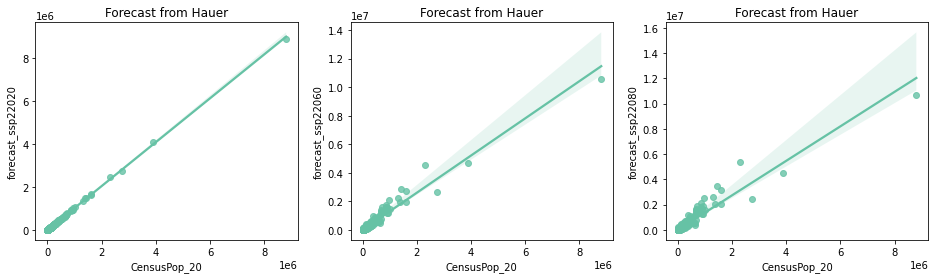

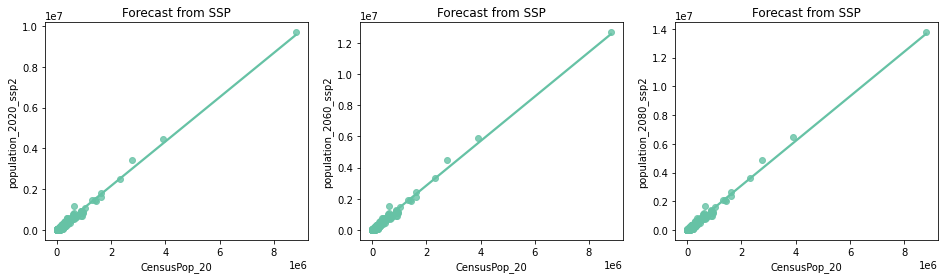

In [166]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(16,4))
ax1.set_title('Forecast from Hauer')
h1 = sns.regplot(x='CensusPop_20', y='forecast_ssp22020', data=df_both_combined, ax=ax1)
# h1.set(xscale="log")

ax2.set_title('Forecast from Hauer')
h2 = sns.regplot(x='CensusPop_20', y='forecast_ssp22060', data=df_both_combined, ax=ax2)
# h2.set(xscale="log")

ax3.set_title('Forecast from Hauer')
h3 = sns.regplot(x='CensusPop_20', y='forecast_ssp22080', data=df_both_combined, ax=ax3)
# h3.set(xscale="log")


fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(16,4))
ax1.set_title('Forecast from SSP')
p1 = sns.regplot(x='CensusPop_20', y='population_2020_ssp2', ci = None, data=df_both_combined, ax=ax1)
# p1.set(xscale="log")

ax2.set_title('Forecast from SSP')
p2 = sns.regplot(x='CensusPop_20', y='population_2060_ssp2', ci = None, data=df_both_combined, ax=ax2)
# p2.set(xscale="log")

ax3.set_title('Forecast from SSP')
p3 = sns.regplot(x='CensusPop_20', y='population_2080_ssp2', ci = None, data=df_both_combined, ax=ax3)
# p3.set(xscale="log")

'''
Forecast from Hauer is distributed as per the ratio of 2020 population, therefore always gives a perfectly matched trend line. 
While using 1kmx1km grided population, an increasing trend towards the larger cities can be found than smaller cities.
Hauer - small cities gaining, large losing
SSP - Small cities are losing, large cities gaining
'''


[None]

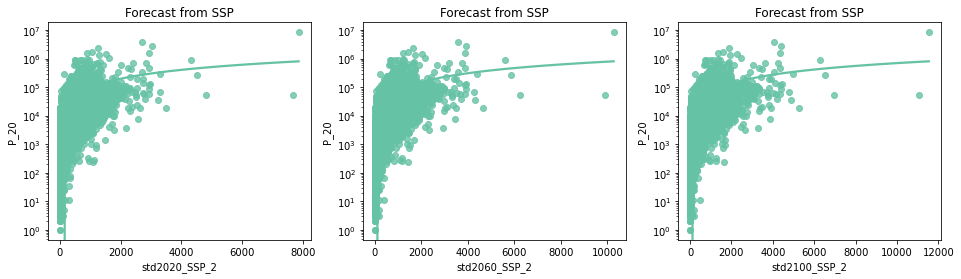

In [117]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(16,4))
ax1.set_title('Forecast from SSP')
std1= sns.regplot(y='P_20', x='std2020_SSP_2', ci = None, data=df_both_combined, ax=ax1)
std1.set(yscale="log")

ax2.set_title('Forecast from SSP')
std2 = sns.regplot(y='P_20', x='std2060_SSP_2', ci = None, data=df_both_combined, ax=ax2)
std2.set(yscale="log")

ax3.set_title('Forecast from SSP')
std3 = sns.regplot(y='P_20', x='std2100_SSP_2', ci = None, data=df_both_combined, ax=ax3)
std3.set(yscale="log")


In [122]:
df_both_combined[['GEOID',  'State', 'NAME10','future trend from SSP 1', 
                  'future trend from SSP 2', 'future trend from SSP 3', 
                  'future trend from SSP 4', 'future trend from SSP 5',
                  'density_km2','trend_SSP_1','trend_SSP_2','trend_SSP_3',
                  'trend_SSP_4','trend_SSP_5',
                  'CensusPop_20']].to_csv(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\forecasted_trend_both.csv')

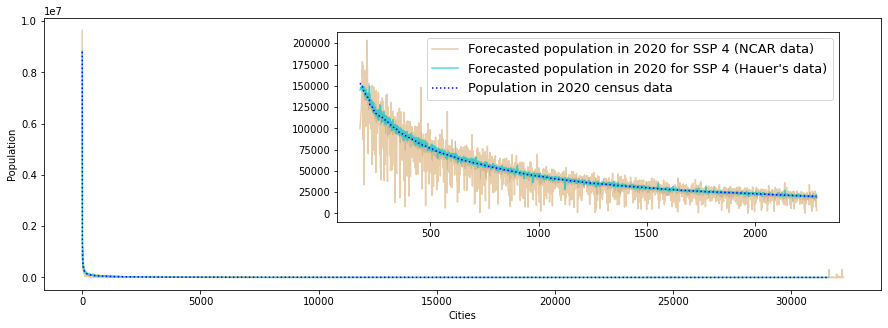

In [157]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df_main = df_both_combined.sort_values('CensusPop_20', ascending = False).reset_index()
df_inset= df_main[(df_main['forecast_ssp42020'] < 150000) & (df_main['CensusPop_20'] > 20000)]

fig, ax = plt.subplots(1, 1, figsize=[15, 5])
ax.plot(df_main.index, df_main['population_2020_ssp4'],"burlywood", alpha = 0.7, label = 'forecasted population 2040 for SSP 4');
ax.plot(df_main.index, df_main['forecast_ssp42020'], "darkturquoise", alpha = 0.7, label = 'forecasted population 2020 for SSP 4');
ax.plot(df_main.index, (df_main['CensusPop_20']), "b", linestyle='dotted', linewidth=1.5, label = 'Population in 2020 census data')

# ax.fill_between(df_main.index, df_main['P_20_upper'], df_main['P_20_lower'], color="grey", alpha=0.5);

# Create inset of mixed specifications in the second subplot;
# width is 30% of parent axes' bounding box and
# height is 1 inch at the upper left corner (loc=2)
#Get artists and labels for legend and chose which ones to display

ax1 = ax.inset_axes((0.35,0.25,.6,.7)) #inset_axes(ax, width="50%", height=2, loc=2, borderpad=5)

ax1.plot(df_inset.index, df_inset['population_2020_ssp4'],"burlywood", alpha = 0.7, label = 'Forecasted population in 2020 for SSP 4 (NCAR data)');
ax1.plot(df_inset.index, df_inset['forecast_ssp42020'], "darkturquoise", alpha = 0.7, label = "Forecasted population in 2020 for SSP 4 (Hauer's data)");
ax1.plot(df_inset.index, (df_inset['CensusPop_20']), "b",linestyle='dotted', linewidth=1.5, label = 'Population in 2020 census data')

ax1.fill_between(df_inset.index, df_inset['P_20_upper'], df_inset['P_20_lower'], color="grey", alpha=0.5);

display = (0,1,2,3,4)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend([handle for i,handle in enumerate(handles) if i in display],
           [label for i,label in enumerate(labels) if i in display], loc = 'upper right', fontsize = 13)


# Turn ticklabels of insets off
for axi in [ax, ax1]:
    axi.tick_params(labelleft=True, labelbottom=True)
ax.set_xlabel('Cities')
ax.set_ylabel('Population')
plt.show()

# fig.savefig(r'D:\Work\Box Sync\Trends_all states\Output from Analysis\Figures\Plot variation in estimation and projected values.png', dpi = 300,
           # bbox_inches='tight', transparent="True", pad_inches=0)